# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Ajudar a desenvolver o mercado artesanal e independente de bolos e doces.
2. Quais cidades brasileiras a Moça deveria iniciar um programa de incentivo ao empreendedorismo gastronômico artesenal.
3. A proposta deverá considerar a sustentabilidade e escabilidade do negócio.

## Output - Saída

1. Apresentar um parâmetro do que seria o mercado artesanal e independente de bolos e doces.
2. Apresentar indicadores que deveríamos considerar para que uma cidade seja potencial escolhida como um local para incentivo ao empreendedorismo gastronômico.
3. Indicar em termos de receita qual seria o potencial do local escolhido e porquê ele é importante.

## Tasks - Processo

1. **Apresentar um parâmetro do que seria o mercado artesanal e independente de bolos e doces.**
    * Qual é o contexto do mercado artesanal de bolos e doces no Brasil ?
            - Como é composto este mercado (sexo, idade, região)
            - Quais os principais mercados
            - Qual é o potencial em cada região
            - Há um grande volume de lojas pequenas de rua com "bolos caseiros". São potenciais fornecedores para a plataforma Vem de Bolo?
            - Pessoas que vendem pela internet (facebook, whatsapp, instagram). Qual o potencial deste mercado?
            - Quais os principais empecilhos para este tipo de mercado? Uma plataforma on-line (Vem de bolo) poderia dar uma escabilidade aos negócios destas pessoas?
            - Qual é a melhor maneira de atingir o público em termos de comunicação?
            
            
2. **Apresentar indicadores que deveríamos considerar para que uma cidade seja potencial escolhida como um local para incentivo ao empreendedorismo gastronômico.**
    * Quais são os fatores relevantes que a Vem de Bolo pode nos ensinar?
         - **Aprendizado via fornecedor:**
            - Qual é o faturamento médio por fonecedor?
            - Como estes fornecedores estão distribuídos? (cidade/localização)
            - O que caracteriza um fornecedor potencial para a plataforma Vem de Bolo? Quais são os atributos desejáveis?
            - Quais as principais formas de entrega por fornecedor?
         - **Aprendizado via clientes:**
            - Qual é o perfil de compra das pessoas que utilizam a plataforma Vem de Bolo?
            - Qual é o valor de desembolso médio das pessoas?
            - Qual é o tipo de produto que as pessoas mais compram pela plataforma? Isto está relacionado a escolha ou ao viés da oferta?
            - O que determina a escolha do cliente para dado fornecedor? O rating é algo importante / fator de escolha?
    
    
3. **3. Indicar em termos de receita qual seria o potencial do local escolhido e porquê ele é importante.**
    * Dentre os indicadores socio-econômicos, o que faz um local ser viável ao negócio Vem de Bolo?
            - Qual seria o potencial de ganho na cidade escolhida?
            - Há escalabilidade onde poderíamos aumentar a margem sem incorrer de grandes custos (adotar uma cidade que poderia ser um "satélite" de uma região
            - Quais seriam os custos que a Moça deveria investir para viabilizar o negócio da plataforma (marketing, negócio, TI)?

# 0.0. Imports

In [220]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection

from scipy import stats as ss
from statsmodels.stats.diagnostic import lilliefors
from sklearn import preprocessing as pp
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import mixture as mx

from plotly import express as px

from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 0.1. Helper Functions

In [134]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply( lambda x: x.unique().shape[0])).T
    
    n = pd.concat([d4, d5, d6, d7], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis', 'unique']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis', 'unique']
    return b[columns]

def normal_test(normality_test):
    alpha = 0.05

    sf_t, k2_t, and_t, q2_t, lf_t, jb_t, ks_t = [[], [], [], [], [], [], []]
    name_columns = normality_test.columns

    for i in normality_test:
        if len(normality_test[i])<50:
            # Shapiro-Wilk Test - SAMPLE < 50
            statistic_wb, pvalue_wb = ss.shapiro(normality_test[i])        
            if pvalue_wb > alpha:
                sf_t = sf_t + ["Yes"]
            else:
                sf_t = sf_t + ["No"]
        else:
            sf_t = sf_t + ['Test not possible']

        # D’Agostino’s K-squared test
        k2, p_k2 = ss.normaltest(normality_test[i])
        if p_k2 > alpha:
            k2_t = k2_t + ["Yes"]
        else:
            k2_t = k2_t + ["No"]

        # Anderson-Darling Normality Test
        and_test = ss.anderson(normality_test[i], dist='norm')
        if and_test.statistic < and_test.critical_values[2]: #alpha = 0.05
            and_t = and_t + ["Yes"]
        else:
            and_t = and_t + ["No"]

        # Chi-Square Normality Test
        statistic_q2, pvalue_q2 = ss.chisquare(normality_test[i])
        if pvalue_q2 > alpha:
            q2_t = q2_t + ["Yes"]
        else:
            q2_t = q2_t + ["No"]

        # Lilliefors Test for Normality
        statistic_lillie, pvalue_lillie = lilliefors(normality_test[i])
        if pvalue_lillie > alpha:
            lf_t = lf_t + ["Yes"]
        else:
            lf_t = lf_t + ["No"]

        #Jarque–Bera test for Normality (SAMPLES > 2000)
        if len(normality_test[i]) > 2000:
            statistic_jb, pvalue_jb = ss.jarque_bera(normality_test[i])
            alpha = 0.05
            if pvalue_jb > alpha:
                jb_t = jb_t + ["Yes"]
            else:
                jb_t = jb_t + ["No"]
        else:
            jb_t = jb_t + ['Test not possible']

        # Kolmogorov-Smirnov test for Normality
        statistic_ks, pvalue_ks = ss.kstest(normality_test[i], 'norm')
        if pvalue_ks > alpha:
            ks_t = ks_t + ["Yes"]
        else:
            ks_t = ks_t + ["No"]

    normal_t = pd.DataFrame([sf_t, k2_t, and_t, q2_t, lf_t, jb_t, ks_t], columns=name_columns).T
    normal_t.columns = ['Shapiro-Wilk Test', 'D’Agostino’s K-squared',
                    'Anderson-Darling', 'Chi-Square',
                    'Lilliefors', 'Jarque–Bera', 'Kolmogorov-Smirnov']
    
    return normal_t

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [7]:
df_addresses = pd.read_csv('../data/raw/tb_addresses.csv', delimiter=';')
df_banners = pd.read_csv('../data/raw/tb_banners.csv', delimiter=';')
df_cities = pd.read_csv('../data/raw/tb_cities.csv', delimiter=';')
df_coupons = pd.read_csv('../data/raw/tb_coupons.csv', delimiter=';')
df_customer_payments = pd.read_csv('../data/raw/tb_customer_payments.csv', delimiter=';')
df_ordered_products = pd.read_csv('../data/raw/tb_ordered_products.csv', delimiter=';')
df_product_tags = pd.read_csv('../data/raw/tb_product_tags.csv', delimiter=';')
df_products = pd.read_csv('../data/raw/tb_products.csv', delimiter=';')
df_ratings = pd.read_csv('../data/raw/tb_ratings.csv', delimiter=';')
df_solds_cognatis = pd.read_csv('../data/raw/tb_solds_cognatis.csv', delimiter=';')
df_users = pd.read_csv('../data/raw/tb_users.csv', delimiter=';')
df_vendor_payments = pd.read_csv('../data/raw/tb_vendor_payments.csv', delimiter=';')
df_vendors = pd.read_csv('../data/raw/tb_vendors.csv', delimiter=';')
df_vendors_delivery_fees = pd.read_csv('../data/raw/tb_vendors_delivery_fees.csv', delimiter=';')

### DF VENDORS T = DF VENDORS + DF VENDORS DELIVERY FEES + DF ADRESSES

#### AJUSTANDO - DF VENDORS DELIVERY FEES

In [68]:
# TIPO TAXA FIXED
# Ajustando o df_vendors_delivery_fees pelo fato de possuir dados repetidos na chave principal dos fornecedores de maneira a criar uma única tabela.
fixed = df_vendors_delivery_fees[df_vendors_delivery_fees['tipo_taxa'] == 'FIXED'].reset_index().drop('index', axis=1)
fixed = fixed.rename(columns={'valor_fixo': 'fixed_valor_fixo', 'distancia_maxima': 'fixed_distancia_maxima'})
fixed = fixed.drop(['valor_minimo', 'valor_por_km', 'valor_cobertura_minima', 'tipo_taxa'], axis=1)

# Agrupando o dado dos fornecedores num único registro.
id_fornecedor = fixed['id_fornecedor'].unique().tolist()
fixed_ndp = fixed.drop_duplicates(subset='id_fornecedor').copy().reset_index().drop('index', axis=1)
fixed_ndp['fixed_valor_fixo'] = ""
fixed_ndp['fixed_distancia_maxima'] = ""
fixed['fixed_valor_fixo'] = fixed['fixed_valor_fixo'].astype('int64')
fixed['fixed_valor_fixo'] = fixed['fixed_valor_fixo'].astype('str')
fixed['fixed_distancia_maxima'] = fixed['fixed_distancia_maxima'].astype('str')
for i in range(len(fixed_ndp)):
    for j in range(len(fixed)):
        if fixed_ndp['id_fornecedor'][i] == fixed['id_fornecedor'][j]:
            fixed_ndp['fixed_valor_fixo'][i] = fixed_ndp['fixed_valor_fixo'][i] + fixed['fixed_valor_fixo'][j] + ' / '
for i in range(len(fixed_ndp)):
    for j in range(len(fixed)):
        if fixed_ndp['id_fornecedor'][i] == fixed['id_fornecedor'][j]:
            fixed_ndp['fixed_distancia_maxima'][i] = fixed_ndp['fixed_distancia_maxima'][i] + fixed['fixed_distancia_maxima'][j] + ' / '
fixed = fixed_ndp.copy()

fixed.shape

(107, 3)

In [69]:
# TIPO TAXA PER_KM
# Ajustando o df_vendors_delivery_fees pelo fato de possuir dados repetidos na chave principal dos fornecedores de maneira a criar uma única tabela.
per_km = df_vendors_delivery_fees[df_vendors_delivery_fees['tipo_taxa'] == 'PER_KM'].reset_index().drop('index', axis=1)
per_km = per_km.rename(columns={'valor_por_km': 'per_km_valor', 'distancia_maxima': 'per_km_distancia_maxima'})
per_km = per_km.drop(['valor_fixo', 'valor_minimo', 'valor_cobertura_minima', 'tipo_taxa'], axis=1)

# Agrupando o dado dos fornecedores num único registro.
id_fornecedor = per_km['id_fornecedor'].unique().tolist()
per_km_ndp = per_km.drop_duplicates(subset='id_fornecedor').copy().reset_index().drop('index', axis=1)
per_km_ndp['per_km_valor'] = ""
per_km_ndp['per_km_distancia_maxima'] = ""
per_km['per_km_valor'] = per_km['per_km_valor'].astype('str')
per_km['per_km_distancia_maxima'] = per_km['per_km_distancia_maxima'].astype('str')
for i in range(len(per_km_ndp)):
    for j in range(len(per_km)):
        if per_km_ndp['id_fornecedor'][i] == per_km['id_fornecedor'][j]:
            per_km_ndp['per_km_valor'][i] = per_km_ndp['per_km_valor'][i] + per_km['per_km_valor'][j] + ' / '
for i in range(len(per_km_ndp)):
    for j in range(len(per_km)):
        if per_km_ndp['id_fornecedor'][i] == per_km['id_fornecedor'][j]:
            per_km_ndp['per_km_distancia_maxima'][i] = per_km_ndp['per_km_distancia_maxima'][i] + per_km['per_km_distancia_maxima'][j] + ' / '
per_km = per_km_ndp.copy()

# MERGING - FIXED + PER_KM
n_df_vendors_delivery = fixed.merge(per_km, on='id_fornecedor', how='left')
n_df_vendors_delivery.isna().sum()

id_fornecedor               0
fixed_valor_fixo            0
fixed_distancia_maxima      0
per_km_valor               88
per_km_distancia_maxima    88
dtype: int64

In [70]:
# TIPO TAXA MIN PLUS PER KM
# Ajustando o df_vendors_delivery_fees pelo fato de possuir dados repetidos na chave principal dos fornecedores de maneira a criar uma única tabela.
min_plus_per_km = df_vendors_delivery_fees[df_vendors_delivery_fees['tipo_taxa'] == 'MIN_PLUS_PER_KM'].reset_index().drop('index', axis=1)
min_plus_per_km = min_plus_per_km.rename(columns={'valor_minimo': 'min_plus_per_km_valor_minimo',
                                                  'valor_por_km': 'min_plus_per_km_valor_por_km',
                                                  'valor_cobertura_minima': 'min_plus_per_km_valor_cobertura_minima',
                                                  'distancia_maxima': 'min_plus_per_km_distancia_maxima',
                                                 })
min_plus_per_km = min_plus_per_km.drop(['valor_fixo', 'tipo_taxa'], axis=1)

# Agrupando o dado dos fornecedores num único registro.
id_fornecedor = min_plus_per_km['id_fornecedor'].unique().tolist()
min_plus_per_km_ndp = min_plus_per_km.drop_duplicates(subset='id_fornecedor').copy().reset_index().drop('index', axis=1)
min_plus_per_km_ndp['min_plus_per_km_valor_minimo'] = ""
min_plus_per_km_ndp['min_plus_per_km_valor_por_km'] = ""
min_plus_per_km_ndp['min_plus_per_km_valor_cobertura_minima'] = ""
min_plus_per_km_ndp['min_plus_per_km_distancia_maxima'] = ""
min_plus_per_km['min_plus_per_km_valor_minimo'] = min_plus_per_km['min_plus_per_km_valor_minimo'].astype('str')
min_plus_per_km['min_plus_per_km_valor_por_km'] = min_plus_per_km['min_plus_per_km_valor_por_km'].astype('str')
min_plus_per_km['min_plus_per_km_valor_cobertura_minima'] = min_plus_per_km['min_plus_per_km_valor_cobertura_minima'].astype('str')
min_plus_per_km['min_plus_per_km_distancia_maxima'] = min_plus_per_km['min_plus_per_km_distancia_maxima'].astype('str')
for i in range(len(min_plus_per_km_ndp)):
    for j in range(len(min_plus_per_km)):
        if min_plus_per_km_ndp['id_fornecedor'][i] == min_plus_per_km['id_fornecedor'][j]:
            min_plus_per_km_ndp['min_plus_per_km_valor_minimo'][i] = min_plus_per_km_ndp['min_plus_per_km_valor_minimo'][i] + min_plus_per_km['min_plus_per_km_valor_minimo'][j] + ' / '
for i in range(len(min_plus_per_km_ndp)):
    for j in range(len(min_plus_per_km)):
        if min_plus_per_km_ndp['id_fornecedor'][i] == min_plus_per_km['id_fornecedor'][j]:
            min_plus_per_km_ndp['min_plus_per_km_valor_por_km'][i] = min_plus_per_km_ndp['min_plus_per_km_valor_por_km'][i] + min_plus_per_km['min_plus_per_km_valor_por_km'][j] + ' / '
for i in range(len(min_plus_per_km_ndp)):
    for j in range(len(min_plus_per_km)):
        if min_plus_per_km_ndp['id_fornecedor'][i] == min_plus_per_km['id_fornecedor'][j]:
            min_plus_per_km_ndp['min_plus_per_km_valor_cobertura_minima'][i] = min_plus_per_km_ndp['min_plus_per_km_valor_cobertura_minima'][i] + min_plus_per_km['min_plus_per_km_valor_cobertura_minima'][j] + ' / '
for i in range(len(min_plus_per_km_ndp)):
    for j in range(len(min_plus_per_km)):
        if min_plus_per_km_ndp['id_fornecedor'][i] == min_plus_per_km['id_fornecedor'][j]:
            min_plus_per_km_ndp['min_plus_per_km_distancia_maxima'][i] = min_plus_per_km_ndp['min_plus_per_km_distancia_maxima'][i] + min_plus_per_km['min_plus_per_km_distancia_maxima'][j] + ' / '
min_plus_per_km = min_plus_per_km_ndp.copy()


# MERGING - N DF VENDORS DELIVERY + MIN PLUS PER_KM
n_df_vendors_delivery = n_df_vendors_delivery.merge(min_plus_per_km, on='id_fornecedor', how='left')
n_df_vendors_delivery.isna().sum()

id_fornecedor                              0
fixed_valor_fixo                           0
fixed_distancia_maxima                     0
per_km_valor                              88
per_km_distancia_maxima                   88
min_plus_per_km_valor_minimo              95
min_plus_per_km_valor_por_km              95
min_plus_per_km_valor_cobertura_minima    95
min_plus_per_km_distancia_maxima          95
dtype: int64

In [71]:
# TIPO TAXA FREE
# Ajustando o df_vendors_delivery_fees pelo fato de possuir dados repetidos na chave principal dos fornecedores de maneira a criar uma única tabela.
free = df_vendors_delivery_fees[df_vendors_delivery_fees['tipo_taxa'] == 'FREE'].reset_index().drop('index', axis=1)
free = free.rename(columns={'distancia_maxima': 'free_distancia_maxima'})
free = free.drop(['valor_fixo', 'valor_minimo','valor_por_km', 'valor_cobertura_minima', 'tipo_taxa'], axis=1)

# Agrupando o dado dos fornecedores num único registro.
id_fornecedor = free['id_fornecedor'].unique().tolist()
free_ndp = free.drop_duplicates(subset='id_fornecedor').copy().reset_index().drop('index', axis=1)
free_ndp['free_distancia_maxima'] = ""
free['free_distancia_maxima'] = free['free_distancia_maxima'].astype('str')
for i in range(len(free_ndp)):
    for j in range(len(free)):
        if free_ndp['id_fornecedor'][i] == free['id_fornecedor'][j]:
            free_ndp['free_distancia_maxima'][i] = free_ndp['free_distancia_maxima'][i] + free['free_distancia_maxima'][j] + ' / '
free = free_ndp.copy()

# MERGING - N DF VENDORS DELIVERY + MIN PLUS PER_KM
n_df_vendors_delivery = n_df_vendors_delivery.merge(free, on='id_fornecedor', how='left')
n_df_vendors_delivery.isna().sum()

id_fornecedor                              0
fixed_valor_fixo                           0
fixed_distancia_maxima                     0
per_km_valor                              88
per_km_distancia_maxima                   88
min_plus_per_km_valor_minimo              95
min_plus_per_km_valor_por_km              95
min_plus_per_km_valor_cobertura_minima    95
min_plus_per_km_distancia_maxima          95
free_distancia_maxima                     86
dtype: int64

In [72]:
# preencher os valores que não são aplicáveis por 0 / criado uma nova coluna para diferenciar quandoe está indicado o valor do delivery para melhorar a filtragem
n_df_vendors_delivery = n_df_vendors_delivery.fillna(0)
n_df_vendors_delivery['preco_delivery'] = 1

In [112]:
df_vendors_delivery_fees.head()

,id_fornecedor,fixed_valor_fixo,fixed_distancia_maxima,per_km_valor,per_km_distancia_maxima,min_plus_per_km_valor_minimo,min_plus_per_km_valor_por_km,min_plus_per_km_valor_cobertura_minima,min_plus_per_km_distancia_maxima,free_distancia_maxima,preco_delivery
0,5f550609cba01d00210ed015,5 /,5 /,0,0,0,0,0,0,0,1
1,5f584189fc58110021464422,9 /,4 /,1.15 /,13 /,0,0,0,0,0,1
2,5f5bc310b8742200213bda1d,5 / 15 / 20 /,5 / 10 / 15 /,0,0,0,0,0,0,0,1
3,5f601c9d70be91002137eb5c,12 /,6 /,0,0,0,0,0,0,0,1
4,5f60ef0070be91002137ebba,8 / 16 / 20 / 23 / 25 /,2 / 4 / 6 / 7 / 8 /,0,0,0,0,0,0,1 /,1


In [73]:
df_vendors_delivery_fees = n_df_vendors_delivery.copy()

#### AJUSTANDO - DF ADRESSES

In [34]:
df_addresses.isna().sum()

id_endereco             0
id_fornecedor       86808
bairro               3762
ponto_referencia    66881
cidade                  0
estado                  0
uf                      0
pais                    0
tipo                    0
cep                  3039
dtype: int64

In [58]:
print('Total de valores únicos', len(df_addresses['id_endereco'].unique()), '/ Total de valores na tabela', df_addresses.shape[0])

Total de valores únicos 87204 / Total de valores na tabela 87217


In [59]:
# Analisando os endereços duplicados, verificou-se que é apenas variação do CEP. Os valores duplicados serão eliminados.
df_addresses = df_addresses.drop_duplicates(subset='id_endereco')
df_addresses.shape

(87204, 10)

#### AJUSTANDO - DF VENDORS

In [61]:
df_vendors.isna().sum()

id_fornecedor         0
nome_fornecedor       0
data_registro         0
qtde_produtos         0
preco_medio           0
avaliacao_media       0
e_aprovado            0
nome_empresa          0
id_endereco           0
delivery_raio_km      0
delivery_sistema    367
hora_abertura         0
hora_fechamento       0
data_aprovacao      209
data_reprovacao     264
dtype: int64

In [62]:
print('Total de valores únicos', len(df_vendors['id_fornecedor'].unique()), '/ Total de valores na tabela', df_vendors.shape[0])

Total de valores únicos 403 / Total de valores na tabela 403


In [64]:
# as colunas abaixo possuem valores 0 em todas as linhas. será retirado do DF.
df_vendors = df_vendors.drop(columns=['qtde_produtos', 'preco_medio', 'avaliacao_media'])

#### JUNTANDO - DF VENDORS + DF VENDORS DELIVERY FEES + DF ADRESSES

In [77]:
# Juntando a tabela DF VENDORS com a VENDORS DELIVERY FEES
df_vendors_t = df_vendors.merge(df_vendors_delivery_fees, on="id_fornecedor", how="left")
df_vendors_t = df_vendors_t.drop(columns='nome_empresa')
# Juntando a tabela DF VENDORS T com a ADRESSES
df_t = df_addresses.drop('id_fornecedor', axis=1) #id_fornecedor está praticamente vazia neste DF.
df_vendors_t = pd.merge(df_vendors_t, df_t, on='id_endereco', how='left')
df_vendors_t = df_vendors_t.drop('id_endereco', axis=1)

In [84]:
dic = { 'data_registro': 'forn_data_registro',
        'qtde_produtos': 'forn_qtde_produtos',
        'preco_medio' : 'forn_preco_medio',
        'avaliacao_media': 'forn_avaliacao_media',
        'e_aprovado': 'forn_e_aprovado',
        'nome_empresa': 'forn_nome_empresa',
        'delivery_raio_km': 'forn_delivery_raio_km',
        'delivery_sistema': 'forn_delivery_sistema',
        'hora_abertura': 'forn_hora_abertura',
        'hora_fechamento': 'forn_hora_fechamento', 
        'data_aprovacao': 'forn_data_aprovacao', 
        'data_reprovacao': 'forn_data_reprovacao', 
        'bairro': 'forn_adress_bairro', 
        'ponto_referencia': 'forn_adress_ponto_referencia', 
        'cidade': 'forn_adress_cidade',
        'estado': 'forn_adress_estado', 
        'uf': 'forn_adress_uf', 
        'pais': 'forn_adress_pais', 
        'tipo': 'forn_adress_tipo_endereco', 
        'cep': 'forn_adress_cep'}
df_vendors_t = df_vendors_t.rename(columns=dic)
df_vendors_t.shape

(403, 28)

In [113]:
df_vendors_t.head()

,id_fornecedor,nome_fornecedor,forc_data_registro,forc_e_aprovado,forc_delivery_raio_km,forc_delivery_sistema,forc_hora_abertura,forc_hora_fechamento,forc_data_aprovacao,forc_data_reprovacao,fixed_valor_fixo,fixed_distancia_maxima,per_km_valor,per_km_distancia_maxima,min_plus_per_km_valor_minimo,min_plus_per_km_valor_por_km,min_plus_per_km_valor_cobertura_minima,min_plus_per_km_distancia_maxima,free_distancia_maxima,preco_delivery,forc_adress_bairro,forc_adress_ponto_referencia,forc_adress_cidade,forc_adress_estado,forc_adress_uf,forc_adress_pais,forc_adress_tipo_endereco,forc_adress_cep
0,5f550609cba01d00210ed015,Meus Bolos,2020-09-06 00:42:34,False,20,THIRD_PARTY,05:30,19:00,2021-06-01 16:22:09,2021-08-10 15:40:47,5 /,5 /,0,0,0,0,0,0,0,1.0,Taquaral,NaN,Campinas,SP,SP,Brasil,HISTORY,13000001.0
1,5f584189fc58110021464422,Moça Doceria,2020-09-09 01:56:25,False,13,NaN,08:00,18:00,2021-02-16 18:25:45,2021-09-09 13:45:56,9 /,4 /,1.15 /,13 /,0,0,0,0,0,1.0,Campo Belo,Ateliê do Doce,São Paulo,São Paulo,SP,Brasil,OFFICE,1000001.0
2,5f5a8be1ccc6c40021a8185f,Cami's Candy,2020-09-10 00:49:18,True,15,NaN,08:00,19:00,2021-08-16 21:06:05,2021-06-25 17:22:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brooklin,NaN,São Paulo,São Paulo,SP,Brasil,OFFICE,1000001.0
3,5f5bc310b8742200213bda1d,Re doces,2020-09-11 01:07:10,True,15,NaN,10:00,17:00,2020-09-30 17:13:38,NaN,5 / 15 / 20 /,5 / 10 / 15 /,0,0,0,0,0,0,0,1.0,Vila Congonhas,NaN,São Paulo,São Paulo,SP,Brasil,OFFICE,1000001.0
4,5f5bd2fcb8742200213bda24,Doceria Luz,2020-09-11 01:07:10,False,13,THIRD_PARTY,11:00,17:00,2021-04-26 20:55:50,2021-04-26 20:55:51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Várzea de Baixo,Edifício 17007 - Open Mall,São Paulo,São Paulo,SP,Brasil,OFFICE,NaN


### DF PRODUCTS T = DF PRODUCTS + DF PRODUCTS TAG + DF VENDORS T

#### AJUSTANDO - DF PRODUCTS TAG

In [86]:
df_product_tags.isna().sum()

tag_produtos_id    0
destacado          0
texto_display      0
tipo               0
dtype: int64

In [87]:
print('Total de valores únicos', len(df_product_tags['tag_produtos_id'].unique()), '/ Total de valores na tabela', df_product_tags.shape[0])

Total de valores únicos 109 / Total de valores na tabela 109


#### AJUSTANDO - DF PRODUCTS

In [88]:
df_products.isna().sum()

id_produto                     0
id_fornecedor                  0
id_disconto                 2888
id_tipo                        1
nome                           0
ativo                          7
aprovado                       0
arquivado                      1
entregavel                     0
recuperavel                    0
tempo_preparacao_minutos       6
avaliacao_media               61
dtype: int64

In [89]:
print('Total de valores únicos', len(df_products['id_produto'].unique()), '/ Total de valores na tabela', df_products.shape[0])

Total de valores únicos 3177 / Total de valores na tabela 3177


#### JUNTANDO - DF PRODUCTS + DF PRODUCTS TAGS

In [90]:
# Juntando a tabela DF PRODUCTS com a PRODUCTS TAG
df_product_tags = df_product_tags.rename(columns={'tag_produtos_id' : 'id_tipo'})
df_products_t = pd.merge(df_products, df_product_tags, on='id_tipo', how='left')
df_products_t = df_products_t.drop('id_tipo', axis=1)
df_products_t.isna().sum()

id_produto                     0
id_fornecedor                  0
id_disconto                 2888
nome                           0
ativo                          7
aprovado                       0
arquivado                      1
entregavel                     0
recuperavel                    0
tempo_preparacao_minutos       6
avaliacao_media               61
destacado                      1
texto_display                  1
tipo                           1
dtype: int64

In [91]:
df_products_t.shape

(3177, 14)

In [92]:
dic = {'id_produto' : 'id_produto', 
       'id_fornecedor' : 'id_fornecedor', 
       'id_disconto' : 'id_desconto', 
       'nome' : 'prod_nome', 
       'ativo' : 'prod_ativo',
       'aprovado' : 'prod_aprovado', 
       'arquivado' : 'prod_arquivado', 
       'entregavel' : 'prod_entregavel', 
       'recuperavel' : 'prod_recuperavel',
       'tempo_preparacao_minutos' : 'prod_tempo_prep_minuto', 
       'avaliacao_media' : 'prod_avaliacao_media', 
       'destacado' : 'prod_tag_destacado',
       'texto_display' : 'prod_tag_texto_display', 
       'tipo' : 'prod_tag_tipo'}
df_products_t = df_products_t.rename(columns=dic)
df_products_t.columns

Index(['id_produto', 'id_fornecedor', 'id_desconto', 'prod_nome', 'prod_ativo',
       'prod_aprovado', 'prod_arquivado', 'prod_entregavel',
       'prod_recuperavel', 'prod_tempo_prep_minuto', 'prod_avaliacao_media',
       'prod_tag_destacado', 'prod_tag_texto_display', 'prod_tag_tipo'],
      dtype='object')

In [93]:
# Juntando a tabela DF PRODUCTS T com a DF VENDORS T
df_products_t = pd.merge(df_products_t, df_vendors_t, on='id_fornecedor', how='left')
df_products_t = df_products_t.drop('id_fornecedor', axis=1)
df_products_t.isna().sum()

id_produto                                   0
id_desconto                               2888
prod_nome                                    0
prod_ativo                                   7
prod_aprovado                                0
prod_arquivado                               1
prod_entregavel                              0
prod_recuperavel                             0
prod_tempo_prep_minuto                       6
prod_avaliacao_media                        61
prod_tag_destacado                           1
prod_tag_texto_display                       1
prod_tag_tipo                                1
nome_fornecedor                              0
forc_data_registro                           0
forc_e_aprovado                              0
forc_delivery_raio_km                        0
forc_delivery_sistema                     2532
forc_hora_abertura                           0
forc_hora_fechamento                         0
forc_data_aprovacao                        153
forc_data_rep

In [94]:
df_products_t.shape

(3177, 40)

### DF USERS

In [95]:
# Sugestão: ainda não fazer merge com a tabela de fornecedores para não poluir a quantidade de colunas
id_fornecedor = df_users[~df_users['id_fornecedor'].isna()]['id_fornecedor'].tolist()
print('Usuários que são também vendedores: ', df_vendors[df_vendors['id_fornecedor'].isin(id_fornecedor)].shape[0])

Usuários que são também vendedores:  403


In [96]:
dic = {'id_usuario': 'id_usuario', 
       'id_fornecedor': 'user_id_fornecedor', 
       'nome_completo': 'user_nome_completo', 
       'data_ultima_compra': 'user_data_ultima_compra',
       'qtde_total_compra': 'user_qtde_total_compra', 
       'gasto_total': 'user_gasto_total',
       'ultima_qtde_compra': 'user_ultima_qtde_compra',
       'ticket_medio': 'user_ticket_medio',
       'aceita_thrid_party_mkt': 'user_aceita_thrid_party_mkt',
       'aceita_mkt': 'user_aceita_mkt'}
df_users = df_users.rename(columns=dic)
df_users.columns

Index(['id_usuario', 'user_id_fornecedor', 'user_nome_completo',
       'user_data_ultima_compra', 'user_qtde_total_compra', 'user_gasto_total',
       'user_ultima_qtde_compra', 'user_ticket_medio',
       'user_aceita_thrid_party_mkt', 'user_aceita_mkt'],
      dtype='object')

### DF CUSTOMER PAYMENTS T = DF CUSTOMER PAYMENTS + DF USERS

#### AJUSTANDO DF CUSTOMER PAYMENTS

In [97]:
df_customer_payments.isna().sum()

id_ordens                0
id_pagamentos_cliente    0
id_cliente               0
data_pagamento           0
valor                    0
status_pagamento         0
metodo_pagamento         0
dtype: int64

In [98]:
print('Total de valores únicos', len(df_customer_payments['id_pagamentos_cliente'].unique()), '/ Total de valores na tabela', df_customer_payments.shape[0])

Total de valores únicos 7277 / Total de valores na tabela 8295


In [111]:
df_customer_payments[['id_pagamentos_cliente', 'id_ordens']].groupby('id_pagamentos_cliente').count().sort_values('id_ordens', ascending=False).head(1500)

,id_ordens
id_pagamentos_cliente,
5fc156d29ce0e20021fdbbda,8
5fbefb467dcc570021f3b278,6
5fbd934f5da74a0021e6129d,6
5fc14ded9ce0e20021fd6ae7,6
605531fce5b3670021fa3451,6
60f188e28ef4ff0021c170e1,5
6041424a317f730021f5b369,5
60f188998ef4ff0021c17042,5
5fbeb8de1c97050021f9766a,5


In [99]:
print('Total de valores únicos', len(df_customer_payments['id_ordens'].unique()), '/ Total de valores na tabela', df_customer_payments.shape[0])

Total de valores únicos 5688 / Total de valores na tabela 8295


In [100]:
print('Total de valores únicos', len(df_customer_payments['id_cliente'].unique()), '/ Total de valores na tabela', df_customer_payments.shape[0])

Total de valores únicos 3076 / Total de valores na tabela 8295


In [10]:
dic = {'id_ordens' : 'id_ordem', 
       'id_pagamentos_cliente' : 'id_pagamentos_cliente', 
       'id_cliente' : 'id_usuario', 
       'data_pagamento' : 'user_pay__data_pagamento',
       'valor' : 'user_pay_valor', 
       'status_pagamento': 'user_pay_status_pagamento', 
       'metodo_pagamento': 'user_pay_metodo_pagamento'}
# Juntando DF CUSTOMER PAYMENTS com a DF USERS
df_customer_payments = df_customer_payments.rename(columns=dic)
df_customer_payments_t = pd.merge(df_customer_payments, df_users, on='id_usuario', how='left')
df_customer_payments_t = df_customer_payments_t.drop('id_usuario', axis=1)
# Não faz sentido manter se o usuário é também fornecedor para esta análise (poderá ser revisada posteriormente)
df_customer_payments_t = df_customer_payments_t.drop('user_id_fornecedor', axis=1)
df_customer_payments_t.isna().sum()

id_ordem                          0
id_pagamentos_cliente             0
user_pay__data_pagamento          0
user_pay_valor                    0
user_pay_status_pagamento         0
user_pay_metodo_pagamento         0
user_nome_completo                0
user_data_ultima_compra        1936
user_qtde_total_compra            1
user_gasto_total                  1
user_ultima_qtde_compra           1
user_ticket_medio                 1
user_aceita_thrid_party_mkt       1
user_aceita_mkt                   1
dtype: int64

### <font color='red'>DF ORDERED PRODUCTS T =  DF ORDERED PRODUCTS + DF PRODUCTS T </font>

**Tabela com os dados vendidos pela plataforma onde está vinculado:**
 - a ordem do pedido com as respectivas informações
 - o nome do produto e os respectivos dados de cadastro
 - o nome do fornecedor e os respectivos dados de cadastro
 - dados do cliente que realizou a compra

In [26]:
# JUNTANDO DF ORDERED PRODUCTS com DF PRODUCS T
dic = {'id_produto_vendido': 'id_produto_vendido', 
       'id_produto': 'id_produto', 
       'id_variacao_selecionada' : 'id_variacao_selecionada',
       'valor_medida': 'order_prod_valor_medida', 
       'tipo_medida' : 'order_prod_tipo_medida', 
       'numero_pessoas_servidas' : 'order_prod_numero_pessoas_servidas', 
       'preco' : 'order_prod_preco',
       'qtde' : 'order_prod_qtde', 
       'anotacao' : 'order_prod_anotacao', 
       'subtotal' : 'order_prod_subtotal', 
       'id_ordem' : 'id_ordem'}
df_ordered_products = df_ordered_products.rename(columns=dic)
df_ordered_products_t = pd.merge(df_ordered_products, df_products_t, on='id_produto', how='left')
df_ordered_products_t = df_ordered_products_t.drop('id_produto', axis=1)
df_ordered_products_t.isna().sum()

id_produto_vendido                               0
id_variacao_selecionada                        146
order_prod_valor_medida                        104
order_prod_tipo_medida                         104
order_prod_numero_pessoas_servidas             106
order_prod_preco                               148
order_prod_qtde                                148
order_prod_anotacao                          32317
order_prod_subtotal                            234
id_ordem                                       234
id_desconto                                  26295
prod_nome                                      162
prod_ativo                                     197
prod_aprovado                                  162
prod_arquivado                                 162
prod_entregavel                                162
prod_recuperavel                               162
prod_tempo_prep_minuto                         197
prod_avaliacao_media                           201
prod_tag_destacado             

In [27]:
df_ordered_products_t = pd.merge(df_ordered_products_t, df_customer_payments_t, on='id_ordem', how='left')
df_ordered_products_t = df_ordered_products_t.drop('id_ordem', axis=1)
df_ordered_products_t.isna().sum()

id_produto_vendido                               0
id_variacao_selecionada                        146
order_prod_valor_medida                        104
order_prod_tipo_medida                         104
order_prod_numero_pessoas_servidas             106
order_prod_preco                               148
order_prod_qtde                                148
order_prod_anotacao                          37229
order_prod_subtotal                            234
id_desconto                                  30307
prod_nome                                      162
prod_ativo                                     203
prod_aprovado                                  162
prod_arquivado                                 162
prod_entregavel                                162
prod_recuperavel                               162
prod_tempo_prep_minuto                         203
prod_avaliacao_media                           207
prod_tag_destacado                             168
prod_tag_texto_display         

In [28]:
df_ordered_products_t.shape

(39189, 61)

# <font color='red'> 1.0. Descrição dos dados </font>

In [63]:
df1 = df_solds_cognatis.copy()
df1.head()

,SETOR_ATIV,UF,MUNICIPIO,CEP,TRABALHADORES,S_RENDA_MEDIA,S_FLUXO_PEDESTRE,S_FLUXO_VEICULOS,S_POP_TOTAL,S_DOM_PART_PERM,S_PCT_CRIANCAS,S_PCT_ADOLESCENTE,S_PCT_JOVENS,S_PCT_ADULTOS,S_PCT_SENIOR,S_PCT_IDOSOS,S_RENDA_MEDIA_FAMILIAR,S_DENSIDADE_POPULACAO_KM2,S_PCT_CLASSE_A,S_PCT_CLASSE_B,S_PCT_CLASSE_C,S_PCT_CLASSE_D,S_PCT_CLASSE_E,S_TX_CRESC_POP,S_TX_CRESC_DOM,S_TX_CRESC_RENDA_MEDIA,S_RENDA_PER_CAPITA,S_COMERCIALIZACAO,S_QTD_EMPRESAS,S_PCT_CNAE_AGRICOLA,S_PCT_CNAE_COMERCIO,S_PCT_CNAE_CONSTR_CIVIL,S_PCT_CNAE_INDUSTRIA,S_PCT_CNAE_SERVICOS,S_PCT_CNAE_OUTROS,S_SEM_FUNC,S_DE_1_4_FUNC,S_DE_5_9_FUNC,S_DE_10_19_FUNC,S_DE_20_49_FUNC,S_DE_50_99_FUNC,S_DE_100_249_FUNC,S_DE_250_499_FUNC,S_DE_500_999_FUNC,S_MAIS1000_FUNC,S_SUPERMERCADO,S_TT_PADARIA,S_ATACADO,S_HIPERMERCADO,S_MINIMERCADO
0,NaN,NaN,NaN,NaN,18776.596364,1852.325903,3.158788,4.933333,61660.275152,22297.529697,12.024473,13.205539,15.781139,31.952715,17.218048,9.818206,5372.332256,5057.621174,5.607006,31.245418,40.717103,19.330109,3.100036,1.702618,3.412485,1.346521,2028.925312,14.765867,7202.386667,0.814317,32.400931,6.790309,8.031730,51.080748,0.500792,4817.477576,708.803636,244.792727,135.844848,79.586667,22.883636,12.442424,4.026667,2.001212,1.670303,8.768485,57.606061,23.126061,2.865455,85.970909
1,NaN,AC,Rio Branco,69900001.0,13125.000000,3502.669922,4.000000,6.000000,53376.000000,17146.000000,15.950000,17.559999,18.250000,30.020000,12.170000,6.050000,2121.070068,4036.810059,0.610000,10.160000,39.750000,40.520000,8.960000,1.440000,3.030000,0.730000,684.109985,9.480000,3624.000000,0.607064,45.226269,4.746137,7.008830,40.590508,1.820000,2757.000000,324.000000,101.000000,71.000000,42.000000,15.000000,15.000000,3.000000,4.000000,2.000000,3.000000,22.000000,3.000000,9.000000,184.000000
2,NaN,AC,Rio Branco,69900001.0,18364.000000,2477.159912,4.000000,6.000000,73460.000000,24698.000000,12.570000,15.060000,17.820000,32.400002,15.480000,6.680000,4266.919922,6317.299805,4.440000,27.270000,40.430000,24.360001,3.490000,1.340000,3.100000,0.780000,1438.170044,12.000000,4795.000000,0.312826,42.168926,6.068822,5.505735,44.671533,1.270000,3295.000000,540.000000,190.000000,131.000000,65.000000,19.000000,19.000000,6.000000,2.000000,2.000000,14.000000,29.000000,27.000000,9.000000,111.000000
3,NaN,AC,Sena Madureira,NaN,960.000000,1225.869995,0.000000,0.000000,26675.500000,7823.500000,14.165000,20.740000,21.139999,29.105000,9.555000,5.300000,1917.375000,46.920000,0.185000,7.225000,26.474999,37.225000,28.889999,3.515000,5.265000,1.840000,564.924988,7.145000,951.500000,0.708593,55.977584,5.074720,6.833748,30.009963,1.400000,708.000000,100.500000,27.000000,12.000000,3.000000,1.000000,0.000000,0.000000,0.500000,0.000000,3.000000,7.500000,5.000000,1.000000,84.000000
4,NaN,AC,Senador Guiomard,NaN,1102.000000,1272.079956,0.000000,1.000000,11183.000000,3732.000000,17.360001,18.510000,19.440001,27.600000,11.130000,5.960000,2074.469971,119.680000,0.270000,10.240000,31.000000,44.160000,14.330000,2.410000,4.130000,1.100000,693.349976,6.180000,559.000000,1.073345,52.415027,5.545617,7.513417,32.558140,0.890000,423.000000,49.000000,14.000000,5.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,10.000000,0.000000,0.000000,42.000000


## 1.1. Rename columuns

In [10]:
df1.columns

Index(['SETOR_ATIV', 'UF', 'MUNICIPIO', 'CEP', 'TRABALHADORES',
       'S_RENDA_MEDIA', 'S_FLUXO_PEDESTRE', 'S_FLUXO_VEICULOS', 'S_POP_TOTAL',
       'S_DOM_PART_PERM', 'S_PCT_CRIANCAS', 'S_PCT_ADOLESCENTE',
       'S_PCT_JOVENS', 'S_PCT_ADULTOS', 'S_PCT_SENIOR', 'S_PCT_IDOSOS',
       'S_RENDA_MEDIA_FAMILIAR', 'S_DENSIDADE_POPULACAO_KM2', 'S_PCT_CLASSE_A',
       'S_PCT_CLASSE_B', 'S_PCT_CLASSE_C', 'S_PCT_CLASSE_D', 'S_PCT_CLASSE_E',
       'S_TX_CRESC_POP', 'S_TX_CRESC_DOM', 'S_TX_CRESC_RENDA_MEDIA',
       'S_RENDA_PER_CAPITA', 'S_COMERCIALIZACAO', 'S_QTD_EMPRESAS',
       'S_PCT_CNAE_AGRICOLA', 'S_PCT_CNAE_COMERCIO', 'S_PCT_CNAE_CONSTR_CIVIL',
       'S_PCT_CNAE_INDUSTRIA', 'S_PCT_CNAE_SERVICOS', 'S_PCT_CNAE_OUTROS',
       'S_SEM_FUNC', 'S_DE_1_4_FUNC', 'S_DE_5_9_FUNC', 'S_DE_10_19_FUNC',
       'S_DE_20_49_FUNC', 'S_DE_50_99_FUNC', 'S_DE_100_249_FUNC',
       'S_DE_250_499_FUNC', 'S_DE_500_999_FUNC', 'S_MAIS1000_FUNC',
       'S_SUPERMERCADO', 'S_TT_PADARIA', 'S_ATACADO', 'S_HIPE

In [64]:
# storing columns names
cols_old = ['SETOR_ATIV', 'UF', 'MUNICIPIO', 'CEP', 'TRABALHADORES',
            'S_RENDA_MEDIA', 'S_FLUXO_PEDESTRE', 'S_FLUXO_VEICULOS', 'S_POP_TOTAL',
            'S_DOM_PART_PERM', 'S_PCT_CRIANCAS', 'S_PCT_ADOLESCENTE',
            'S_PCT_JOVENS', 'S_PCT_ADULTOS', 'S_PCT_SENIOR', 'S_PCT_IDOSOS',
            'S_RENDA_MEDIA_FAMILIAR', 'S_DENSIDADE_POPULACAO_KM2', 'S_PCT_CLASSE_A',
            'S_PCT_CLASSE_B', 'S_PCT_CLASSE_C', 'S_PCT_CLASSE_D', 'S_PCT_CLASSE_E',
            'S_TX_CRESC_POP', 'S_TX_CRESC_DOM', 'S_TX_CRESC_RENDA_MEDIA',
            'S_RENDA_PER_CAPITA', 'S_COMERCIALIZACAO', 'S_QTD_EMPRESAS',
            'S_PCT_CNAE_AGRICOLA', 'S_PCT_CNAE_COMERCIO', 'S_PCT_CNAE_CONSTR_CIVIL',
            'S_PCT_CNAE_INDUSTRIA', 'S_PCT_CNAE_SERVICOS', 'S_PCT_CNAE_OUTROS',
            'S_SEM_FUNC', 'S_DE_1_4_FUNC', 'S_DE_5_9_FUNC', 'S_DE_10_19_FUNC',
            'S_DE_20_49_FUNC', 'S_DE_50_99_FUNC', 'S_DE_100_249_FUNC',
            'S_DE_250_499_FUNC', 'S_DE_500_999_FUNC', 'S_MAIS1000_FUNC',
            'S_SUPERMERCADO', 'S_TT_PADARIA', 'S_ATACADO', 'S_HIPERMERCADO',
            'S_MINIMERCADO']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

In [15]:
df1.head()

,setor_ativ,uf,municipio,cep,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_pop_total,s_dom_part_perm,s_pct_criancas,s_pct_adolescente,s_pct_jovens,s_pct_adultos,s_pct_senior,s_pct_idosos,s_renda_media_familiar,s_densidade_populacao_km2,s_pct_classe_a,s_pct_classe_b,s_pct_classe_c,s_pct_classe_d,s_pct_classe_e,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_renda_per_capita,s_comercializacao,s_qtd_empresas,s_pct_cnae_agricola,s_pct_cnae_comercio,s_pct_cnae_constr_civil,s_pct_cnae_industria,s_pct_cnae_servicos,s_pct_cnae_outros,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado
0,NaN,NaN,NaN,NaN,18776.596364,1852.325903,3.158788,4.933333,61660.275152,22297.529697,12.024473,13.205539,15.781139,31.952715,17.218048,9.818206,5372.332256,5057.621174,5.607006,31.245418,40.717103,19.330109,3.100036,1.702618,3.412485,1.346521,2028.925312,14.765867,7202.386667,0.814317,32.400931,6.790309,8.031730,51.080748,0.500792,4817.477576,708.803636,244.792727,135.844848,79.586667,22.883636,12.442424,4.026667,2.001212,1.670303,8.768485,57.606061,23.126061,2.865455,85.970909
1,NaN,AC,Rio Branco,69900001.0,13125.000000,3502.669922,4.000000,6.000000,53376.000000,17146.000000,15.950000,17.559999,18.250000,30.020000,12.170000,6.050000,2121.070068,4036.810059,0.610000,10.160000,39.750000,40.520000,8.960000,1.440000,3.030000,0.730000,684.109985,9.480000,3624.000000,0.607064,45.226269,4.746137,7.008830,40.590508,1.820000,2757.000000,324.000000,101.000000,71.000000,42.000000,15.000000,15.000000,3.000000,4.000000,2.000000,3.000000,22.000000,3.000000,9.000000,184.000000
2,NaN,AC,Rio Branco,69900001.0,18364.000000,2477.159912,4.000000,6.000000,73460.000000,24698.000000,12.570000,15.060000,17.820000,32.400002,15.480000,6.680000,4266.919922,6317.299805,4.440000,27.270000,40.430000,24.360001,3.490000,1.340000,3.100000,0.780000,1438.170044,12.000000,4795.000000,0.312826,42.168926,6.068822,5.505735,44.671533,1.270000,3295.000000,540.000000,190.000000,131.000000,65.000000,19.000000,19.000000,6.000000,2.000000,2.000000,14.000000,29.000000,27.000000,9.000000,111.000000
3,NaN,AC,Sena Madureira,NaN,960.000000,1225.869995,0.000000,0.000000,26675.500000,7823.500000,14.165000,20.740000,21.139999,29.105000,9.555000,5.300000,1917.375000,46.920000,0.185000,7.225000,26.474999,37.225000,28.889999,3.515000,5.265000,1.840000,564.924988,7.145000,951.500000,0.708593,55.977584,5.074720,6.833748,30.009963,1.400000,708.000000,100.500000,27.000000,12.000000,3.000000,1.000000,0.000000,0.000000,0.500000,0.000000,3.000000,7.500000,5.000000,1.000000,84.000000
4,NaN,AC,Senador Guiomard,NaN,1102.000000,1272.079956,0.000000,1.000000,11183.000000,3732.000000,17.360001,18.510000,19.440001,27.600000,11.130000,5.960000,2074.469971,119.680000,0.270000,10.240000,31.000000,44.160000,14.330000,2.410000,4.130000,1.100000,693.349976,6.180000,559.000000,1.073345,52.415027,5.545617,7.513417,32.558140,0.890000,423.000000,49.000000,14.000000,5.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,10.000000,0.000000,0.000000,42.000000


## 1.2. Data dimensions

In [16]:
df1.shape

(82391, 50)

## 1.3. Data types

In [40]:
#df1 = df1['cep'].astype('int64')
df1.dtypes

setor_ativ                    object
uf                            object
municipio                     object
cep                          float64
trabalhadores                float64
s_renda_media                float64
s_fluxo_pedestre             float64
s_fluxo_veiculos             float64
s_pop_total                  float64
s_dom_part_perm              float64
s_pct_criancas               float64
s_pct_adolescente            float64
s_pct_jovens                 float64
s_pct_adultos                float64
s_pct_senior                 float64
s_pct_idosos                 float64
s_renda_media_familiar       float64
s_densidade_populacao_km2    float64
s_pct_classe_a               float64
s_pct_classe_b               float64
s_pct_classe_c               float64
s_pct_classe_d               float64
s_pct_classe_e               float64
s_tx_cresc_pop               float64
s_tx_cresc_dom               float64
s_tx_cresc_renda_media       float64
s_renda_per_capita           float64
s

## 1.4. Check NA

In [59]:
df1.isna().sum()

setor_ativ                   0
uf                           0
municipio                    0
cep                          0
trabalhadores                0
s_renda_media                0
s_fluxo_pedestre             0
s_fluxo_veiculos             0
s_pop_total                  0
s_dom_part_perm              0
s_pct_criancas               0
s_pct_adolescente            0
s_pct_jovens                 0
s_pct_adultos                0
s_pct_senior                 0
s_pct_idosos                 0
s_renda_media_familiar       0
s_densidade_populacao_km2    0
s_pct_classe_a               0
s_pct_classe_b               0
s_pct_classe_c               0
s_pct_classe_d               0
s_pct_classe_e               0
s_tx_cresc_pop               0
s_tx_cresc_dom               0
s_tx_cresc_renda_media       0
s_renda_per_capita           0
s_comercializacao            0
s_qtd_empresas               0
s_pct_cnae_agricola          0
s_pct_cnae_comercio          0
s_pct_cnae_constr_civil      0
s_pct_cn

## 1.5. Replace NA

In [65]:
# FILL NA WITH
# Setor Atividade
df1['setor_ativ'] = df1['setor_ativ'].fillna('INDEFINIDO')

# UF
df1['uf'] = df1['uf'].fillna('SUF')

# Município
df1['municipio'] = df1['municipio'].fillna('SMUNIC')

# CEP
df1['cep'] = df1['cep'].fillna('999')

## 1.6. Change dtypes

In [91]:
df1['cep'] = df1['cep'].astype('int64')

In [88]:
df1.iloc[:, 3:] = df1.iloc[:, 3:].apply(lambda x: np.round(x, 3))

## 1.7. Descriptive Statistics

In [93]:
num_attributes = df1.select_dtypes(include=['int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attibutes

In [94]:
describe_num(num_attributes)

,attibutes,count,mean,std,25%,50%,75%,min,max,range,skew,kurtosis,unique
0,trabalhadores,82391.0,14437.955731,30416.026342,1844.0000,6011.000,14560.0000,0.00,450359.000,450359.000,6.279976,52.677955,39771.0
1,s_renda_media,82391.0,1790.208134,804.285201,1309.3270,1604.680,2012.4475,0.00,30685.597,30685.597,3.795345,51.456079,67964.0
2,s_fluxo_pedestre,82391.0,2.942633,1.505637,2.0000,3.000,4.0000,0.00,5.000,5.000,-0.558736,-0.630197,669.0
3,s_fluxo_veiculos,82391.0,4.826374,1.619187,5.0000,5.000,6.0000,0.00,6.000,6.000,-1.911015,2.956677,887.0
4,s_pop_total,82391.0,52951.995771,39630.572132,24174.0000,44172.000,72931.5000,0.00,286481.500,286481.500,1.162473,1.463079,62357.0
5,s_dom_part_perm,82391.0,18914.705402,14810.317210,8296.0000,15526.000,25863.2500,0.00,118235.000,118235.000,1.438678,3.105090,46772.0
6,s_pct_criancas,82391.0,12.377908,2.813164,10.5400,12.370,14.1700,0.00,60.350,60.350,0.339652,2.850915,7307.0
7,s_pct_adolescente,82391.0,13.461731,2.542402,11.7900,13.500,15.1000,0.00,33.330,33.330,0.144017,0.660952,7205.0
8,s_pct_jovens,82391.0,16.138675,1.848945,14.9500,16.030,17.1900,0.00,66.660,66.660,0.936510,14.617326,6140.0
9,s_pct_adultos,82391.0,31.755913,2.565384,30.1900,31.900,33.3400,0.00,48.670,48.670,-0.221927,1.812689,7409.0


### 1.7.2. Categorical Attibutes

In [95]:
cat_attributes.apply( lambda x: x.unique().shape[0])

setor_ativ       7
uf              28
municipio     6024
cep           5249
dtype: int64

# <font color='red'> 2.0. Feature Engineering </font>

In [235]:
df2 = df1.copy()

In [242]:
df2_ = df2.groupby(['uf','municipio']).sum().reset_index()
df2_['setor_ativ'] = df2[['uf','municipio', 'setor_ativ']].groupby(['uf','municipio']).count().reset_index()['setor_ativ'].values
df2_['uf_municipio'] = df2_['uf'] + ' / ' + df2_['municipio']
df2_ = df2_.drop(columns=['municipio', 'uf', 'cep'])

In [243]:
df2_.head(30)

,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_pop_total,s_dom_part_perm,s_pct_criancas,s_pct_adolescente,s_pct_jovens,s_pct_adultos,s_pct_senior,s_pct_idosos,s_renda_media_familiar,s_densidade_populacao_km2,s_pct_classe_a,s_pct_classe_b,s_pct_classe_c,s_pct_classe_d,s_pct_classe_e,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_renda_per_capita,s_comercializacao,s_qtd_empresas,s_pct_cnae_agricola,s_pct_cnae_comercio,s_pct_cnae_constr_civil,s_pct_cnae_industria,s_pct_cnae_servicos,s_pct_cnae_outros,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,setor_ativ,uf_municipio
0,984.583,3275.396,0.000,0.000,1.420317e+04,4647.917,33.354,39.149,43.530,51.630,20.171,12.147,3155.950,96.888,0.293,9.244,53.144,86.422,50.898,6.954,11.102,0.550,1038.227,11.910,822.083,2.445,92.585,7.517,21.214,68.465,7.489,634.417,74.833,27.583,7.667,3.833,2.000,1.833,0.000,0.000,0.000,9.333,16.583,1.833,0.000,33.250,2,AC / ACRELANDIA
1,5552.071,3573.109,0.000,0.000,5.468121e+04,18692.071,47.891,53.869,61.321,85.290,32.774,18.839,5534.346,5898.858,0.710,27.783,78.495,122.922,70.072,9.666,15.159,-1.881,1904.889,30.599,3955.571,0.856,183.710,10.237,15.910,85.624,3.669,2782.071,416.500,124.571,49.857,12.143,2.857,3.643,1.000,2.857,0.000,51.857,44.857,53.429,9.643,191.143,3,AC / BRASILEIA
2,1296.000,4918.170,0.000,0.000,1.588200e+04,4854.000,49.080,66.570,68.970,73.110,27.930,14.340,5371.170,316.740,0.000,12.420,81.390,130.170,76.020,24.360,28.800,5.790,1645.020,17.460,894.000,10.068,137.919,11.073,30.201,103.692,7.050,726.000,66.000,15.000,9.000,0.000,3.000,0.000,3.000,0.000,0.000,6.000,9.000,6.000,3.000,36.000,3,AC / CAPIXABA
3,12300.518,4661.355,5.556,11.259,1.223164e+05,34380.481,67.384,84.996,81.034,110.332,37.329,18.908,7040.787,4273.300,2.598,31.581,98.521,159.245,108.032,11.553,22.211,3.385,1978.355,43.208,8267.371,1.760,197.183,17.746,28.091,152.265,2.760,6163.463,746.019,239.056,136.444,73.000,17.111,3.241,0.703,0.000,2.074,69.445,55.574,86.741,7.334,757.426,4,AC / CRUZEIRO DO SUL
4,1659.118,1247.426,0.000,0.000,1.267212e+04,4344.294,17.721,18.045,20.228,27.495,10.671,5.835,1721.901,1188.041,0.429,9.239,24.962,41.403,23.958,2.965,4.888,0.386,593.696,9.656,1016.059,0.205,60.530,2.595,5.837,29.361,1.461,696.000,116.588,37.412,13.882,3.824,0.412,1.882,0.941,0.412,0.000,13.765,9.529,15.353,2.941,47.471,1,AC / EPITACIOLANDIA
5,1231.600,2553.049,0.000,0.900,1.880620e+04,5107.200,44.770,47.320,38.706,44.124,19.268,5.809,1872.941,26.227,0.121,7.107,26.670,67.455,98.648,-11.430,-6.198,3.764,506.300,7.126,1065.500,1.327,96.609,7.972,13.828,78.936,1.265,880.900,86.400,19.800,9.900,0.900,0.000,0.900,1.800,0.000,0.000,7.300,15.100,2.500,9.000,189.900,2,AC / FEIJO
6,1064.600,2138.890,0.000,0.000,1.771720e+04,5032.400,34.798,44.786,40.364,52.732,17.962,9.360,3147.872,233.848,0.000,9.706,38.604,86.798,64.892,8.842,12.970,4.318,895.128,10.622,484.000,0.563,110.372,7.795,12.817,65.005,3.444,363.800,40.400,9.400,1.800,4.800,1.600,0.000,1.600,0.000,0.000,8.800,7.200,2.000,1.600,44.200,2,AC / MANCIO LIMA
7,515.417,4816.248,0.000,0.000,1.633908e+04,5344.417,49.678,62.067,56.396,78.764,34.878,18.196,3689.372,191.568,0.721,14.636,92.341,135.260,57.038,3.647,9.868,-1.192,1216.209,14.958,499.417,0.233,158.910,3.818,25.586,110.009,1.423,402.500,40.833,7.167,8.167,0.000,0.000,0.000,0.667,0.000,0.000,7.333,3.500,2.667,0.750,58.833,3,AC / PLACIDO DE CASTRO
8,2670339.833,383071.490,567.500,1159.917,1.073016e+07,3531742.751,3287.888,3741.101,4152.311,7259.314,2820.100,1139.354,781628.442,610679.588,695.939,4705.703,8905.339,6814.369,1278.712,661.624,1035.073,241.165,259280.799,1909.873,651531.833,89.330,10056.178,1316.399,1485.152,9197.754,245.460,468060.000,63263.999,22186.250,15511.666,8581.667,2768.500,2263.500,609.583,321.583,242.500,1506.917,4602.583,4316.500,984.917,25019.333,224,A

In [244]:
df2 = df2_.copy()

# <font color='red'> 3.0. Filtragem de Variaveis </font>

## 3.1. Row Filtering

## 3.2. Column Filtering

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

# <font color='red'> 5.0. Data Preparation </font>

In [245]:
df5 = df2.copy()
df5.head()

,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_pop_total,s_dom_part_perm,s_pct_criancas,s_pct_adolescente,s_pct_jovens,s_pct_adultos,s_pct_senior,s_pct_idosos,s_renda_media_familiar,s_densidade_populacao_km2,s_pct_classe_a,s_pct_classe_b,s_pct_classe_c,s_pct_classe_d,s_pct_classe_e,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_renda_per_capita,s_comercializacao,s_qtd_empresas,s_pct_cnae_agricola,s_pct_cnae_comercio,s_pct_cnae_constr_civil,s_pct_cnae_industria,s_pct_cnae_servicos,s_pct_cnae_outros,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,setor_ativ,uf_municipio
0,984.583,3275.396,0.000,0.000,14203.167,4647.917,33.354,39.149,43.530,51.630,20.171,12.147,3155.950,96.888,0.293,9.244,53.144,86.422,50.898,6.954,11.102,0.550,1038.227,11.910,822.083,2.445,92.585,7.517,21.214,68.465,7.489,634.417,74.833,27.583,7.667,3.833,2.000,1.833,0.000,0.000,0.000,9.333,16.583,1.833,0.000,33.250,2,AC / ACRELANDIA
1,5552.071,3573.109,0.000,0.000,54681.214,18692.071,47.891,53.869,61.321,85.290,32.774,18.839,5534.346,5898.858,0.710,27.783,78.495,122.922,70.072,9.666,15.159,-1.881,1904.889,30.599,3955.571,0.856,183.710,10.237,15.910,85.624,3.669,2782.071,416.500,124.571,49.857,12.143,2.857,3.643,1.000,2.857,0.000,51.857,44.857,53.429,9.643,191.143,3,AC / BRASILEIA
2,1296.000,4918.170,0.000,0.000,15882.000,4854.000,49.080,66.570,68.970,73.110,27.930,14.340,5371.170,316.740,0.000,12.420,81.390,130.170,76.020,24.360,28.800,5.790,1645.020,17.460,894.000,10.068,137.919,11.073,30.201,103.692,7.050,726.000,66.000,15.000,9.000,0.000,3.000,0.000,3.000,0.000,0.000,6.000,9.000,6.000,3.000,36.000,3,AC / CAPIXABA
3,12300.518,4661.355,5.556,11.259,122316.426,34380.481,67.384,84.996,81.034,110.332,37.329,18.908,7040.787,4273.300,2.598,31.581,98.521,159.245,108.032,11.553,22.211,3.385,1978.355,43.208,8267.371,1.760,197.183,17.746,28.091,152.265,2.760,6163.463,746.019,239.056,136.444,73.000,17.111,3.241,0.703,0.000,2.074,69.445,55.574,86.741,7.334,757.426,4,AC / CRUZEIRO DO SUL
4,1659.118,1247.426,0.000,0.000,12672.118,4344.294,17.721,18.045,20.228,27.495,10.671,5.835,1721.901,1188.041,0.429,9.239,24.962,41.403,23.958,2.965,4.888,0.386,593.696,9.656,1016.059,0.205,60.530,2.595,5.837,29.361,1.461,696.000,116.588,37.412,13.882,3.824,0.412,1.882,0.941,0.412,0.000,13.765,9.529,15.353,2.941,47.471,1,AC / EPITACIOLANDIA


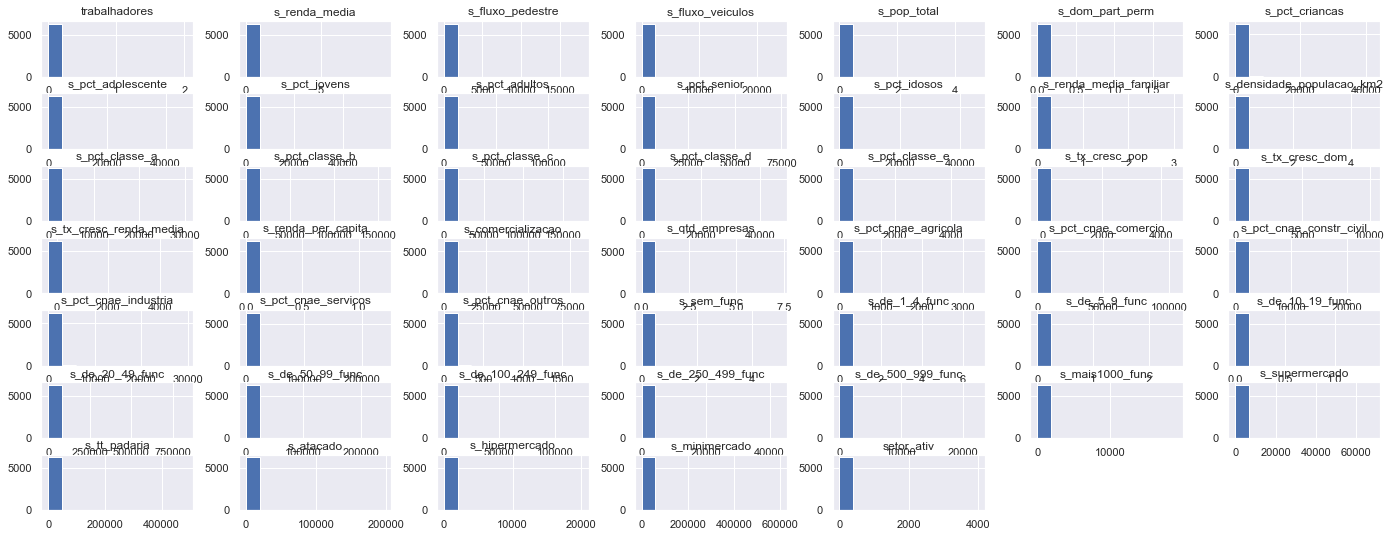

In [246]:
df5.hist();

In [247]:
num_attributes = df5.select_dtypes(include=['int32', 'float64'])
cat_attributes = df5.select_dtypes(exclude=['int32', 'float64', 'datetime64[ns]'])

## 5.1. NORMALIZATION

In [248]:
normal_test(num_attributes)

,Shapiro-Wilk Test,D’Agostino’s K-squared,Anderson-Darling,Chi-Square,Lilliefors,Jarque–Bera,Kolmogorov-Smirnov
trabalhadores,Test not possible,No,No,No,No,No,No
s_renda_media,Test not possible,No,No,No,No,No,No
s_fluxo_pedestre,Test not possible,No,No,No,No,No,No
s_fluxo_veiculos,Test not possible,No,No,No,No,No,No
s_pop_total,Test not possible,No,No,No,No,No,No
s_dom_part_perm,Test not possible,No,No,No,No,No,No
s_pct_criancas,Test not possible,No,No,No,No,No,No
s_pct_adolescente,Test not possible,No,No,No,No,No,No
s_pct_jovens,Test not possible,No,No,No,No,No,No
s_pct_adultos,Test not possible,No,No,No,No,No,No


## 5.2. RESCALLING

In [249]:
df5_p = df5.copy()
df5 = df5.drop(columns='uf_municipio')
df5.head()

,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_pop_total,s_dom_part_perm,s_pct_criancas,s_pct_adolescente,s_pct_jovens,s_pct_adultos,s_pct_senior,s_pct_idosos,s_renda_media_familiar,s_densidade_populacao_km2,s_pct_classe_a,s_pct_classe_b,s_pct_classe_c,s_pct_classe_d,s_pct_classe_e,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_renda_per_capita,s_comercializacao,s_qtd_empresas,s_pct_cnae_agricola,s_pct_cnae_comercio,s_pct_cnae_constr_civil,s_pct_cnae_industria,s_pct_cnae_servicos,s_pct_cnae_outros,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,setor_ativ
0,984.583,3275.396,0.000,0.000,14203.167,4647.917,33.354,39.149,43.530,51.630,20.171,12.147,3155.950,96.888,0.293,9.244,53.144,86.422,50.898,6.954,11.102,0.550,1038.227,11.910,822.083,2.445,92.585,7.517,21.214,68.465,7.489,634.417,74.833,27.583,7.667,3.833,2.000,1.833,0.000,0.000,0.000,9.333,16.583,1.833,0.000,33.250,2
1,5552.071,3573.109,0.000,0.000,54681.214,18692.071,47.891,53.869,61.321,85.290,32.774,18.839,5534.346,5898.858,0.710,27.783,78.495,122.922,70.072,9.666,15.159,-1.881,1904.889,30.599,3955.571,0.856,183.710,10.237,15.910,85.624,3.669,2782.071,416.500,124.571,49.857,12.143,2.857,3.643,1.000,2.857,0.000,51.857,44.857,53.429,9.643,191.143,3
2,1296.000,4918.170,0.000,0.000,15882.000,4854.000,49.080,66.570,68.970,73.110,27.930,14.340,5371.170,316.740,0.000,12.420,81.390,130.170,76.020,24.360,28.800,5.790,1645.020,17.460,894.000,10.068,137.919,11.073,30.201,103.692,7.050,726.000,66.000,15.000,9.000,0.000,3.000,0.000,3.000,0.000,0.000,6.000,9.000,6.000,3.000,36.000,3
3,12300.518,4661.355,5.556,11.259,122316.426,34380.481,67.384,84.996,81.034,110.332,37.329,18.908,7040.787,4273.300,2.598,31.581,98.521,159.245,108.032,11.553,22.211,3.385,1978.355,43.208,8267.371,1.760,197.183,17.746,28.091,152.265,2.760,6163.463,746.019,239.056,136.444,73.000,17.111,3.241,0.703,0.000,2.074,69.445,55.574,86.741,7.334,757.426,4
4,1659.118,1247.426,0.000,0.000,12672.118,4344.294,17.721,18.045,20.228,27.495,10.671,5.835,1721.901,1188.041,0.429,9.239,24.962,41.403,23.958,2.965,4.888,0.386,593.696,9.656,1016.059,0.205,60.530,2.595,5.837,29.361,1.461,696.000,116.588,37.412,13.882,3.824,0.412,1.882,0.941,0.412,0.000,13.765,9.529,15.353,2.941,47.471,1


In [250]:
for i in range(df5.shape[1]):
    mm = pp.MinMaxScaler()
    df5.iloc[:, i] = mm.fit_transform(df5.iloc[:, i].values.reshape(-1, 1))

In [251]:
df5.head()

,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_pop_total,s_dom_part_perm,s_pct_criancas,s_pct_adolescente,s_pct_jovens,s_pct_adultos,s_pct_senior,s_pct_idosos,s_renda_media_familiar,s_densidade_populacao_km2,s_pct_classe_a,s_pct_classe_b,s_pct_classe_c,s_pct_classe_d,s_pct_classe_e,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_renda_per_capita,s_comercializacao,s_qtd_empresas,s_pct_cnae_agricola,s_pct_cnae_comercio,s_pct_cnae_constr_civil,s_pct_cnae_industria,s_pct_cnae_servicos,s_pct_cnae_outros,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,setor_ativ
0,0.000005,0.000355,0.00000,0.000000,0.000029,0.000026,0.000690,0.000675,0.000583,0.000248,0.000198,0.000222,0.000085,0.000002,0.000010,0.000059,0.000282,0.001844,0.010270,0.037280,0.002497,0.061000,0.000072,0.000145,0.000011,0.000729,0.000881,0.000303,0.000716,0.000288,0.004282,0.000013,0.000011,0.000011,0.000006,0.000005,0.000008,0.000015,0.000000,0.000000,0.00000,0.000136,0.000034,0.000009,0.000000,0.000055,0.00025
1,0.000027,0.000387,0.00000,0.000000,0.000114,0.000104,0.001033,0.000987,0.000895,0.000501,0.000367,0.000368,0.000163,0.000124,0.000023,0.000177,0.000428,0.002627,0.014139,0.037861,0.002891,0.060545,0.000142,0.000373,0.000054,0.000255,0.001748,0.000412,0.000537,0.000360,0.002098,0.000055,0.000062,0.000050,0.000036,0.000015,0.000012,0.000029,0.000023,0.000128,0.00000,0.000757,0.000092,0.000270,0.000480,0.000319,0.00050
2,0.000006,0.000533,0.00000,0.000000,0.000033,0.000027,0.001061,0.001257,0.001029,0.000410,0.000302,0.000270,0.000157,0.000007,0.000000,0.000079,0.000444,0.002783,0.015339,0.041013,0.004215,0.061981,0.000121,0.000213,0.000012,0.003000,0.001312,0.000446,0.001019,0.000436,0.004031,0.000014,0.000010,0.000006,0.000006,0.000000,0.000012,0.000000,0.000069,0.000000,0.00000,0.000088,0.000018,0.000030,0.000149,0.000060,0.00050
3,0.000061,0.000505,0.00031,0.000471,0.000256,0.000191,0.001493,0.001648,0.001241,0.000689,0.000429,0.000369,0.000212,0.000089,0.000086,0.000201,0.000543,0.003406,0.021798,0.038266,0.003575,0.061531,0.000148,0.000526,0.000113,0.000524,0.001876,0.000715,0.000948,0.000640,0.001578,0.000123,0.000111,0.000097,0.000098,0.000088,0.000071,0.000026,0.000016,0.000000,0.00011,0.001013,0.000114,0.000438,0.000365,0.001262,0.00075
4,0.000008,0.000135,0.00000,0.000000,0.000026,0.000024,0.000321,0.000227,0.000174,0.000067,0.000070,0.000085,0.000037,0.000025,0.000014,0.000059,0.000120,0.000879,0.004834,0.036424,0.001894,0.060969,0.000036,0.000118,0.000014,0.000061,0.000576,0.000105,0.000197,0.000123,0.000835,0.000014,0.000017,0.000015,0.000010,0.000005,0.000002,0.000015,0.000022,0.000018,0.00000,0.000201,0.000020,0.000078,0.000146,0.000079,0.00000


## 5.3. TRANSFORMATION

# <font color='red'> 6.0. Feature Selection </font>

# <font color='red'> 7.0 MACHINE LEARNING MODELLING </font>

In [252]:
X = df5.copy()

In [253]:
clusters = [2, 3, 4, 5, 6, 7]

In [254]:
X.shape

(6305, 47)

## 7.1. Defining the number of Clusers - K-Means

In [255]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )
    #print('Cluster: ', k, 'Silhoutte Score: ', sil)

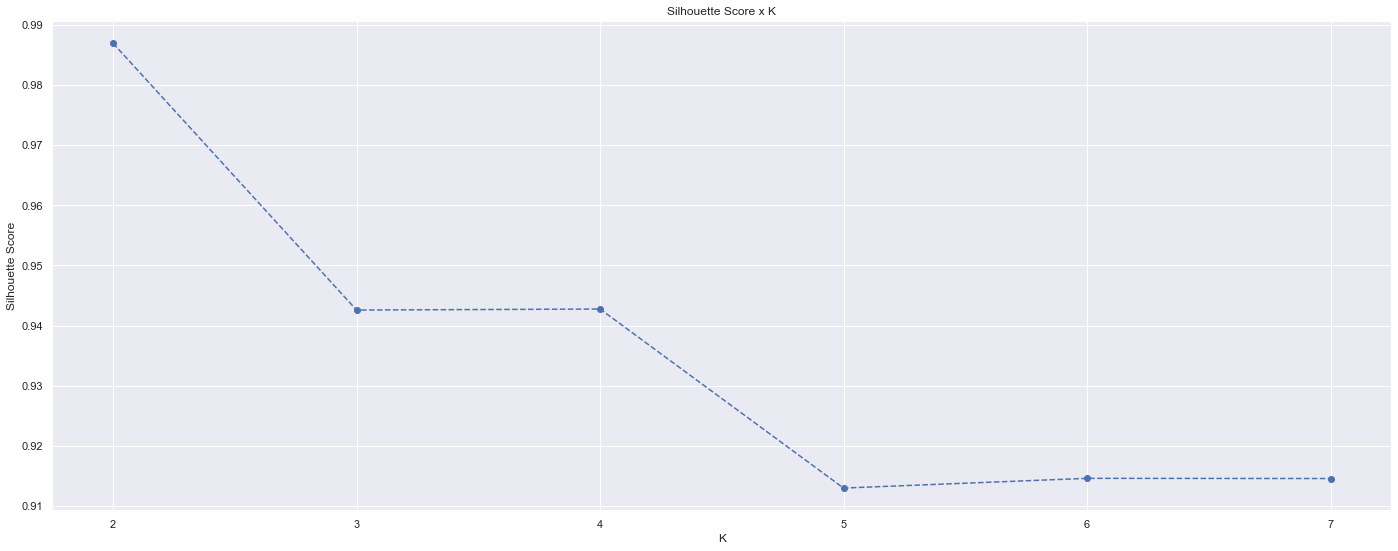

In [256]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [257]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

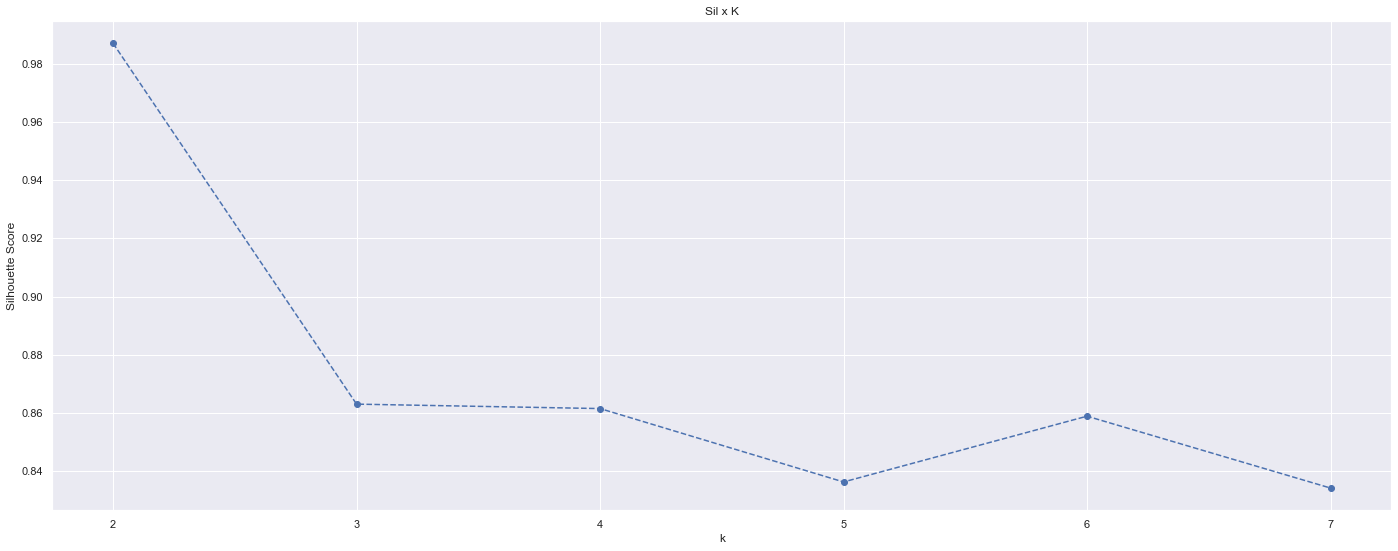

In [258]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

In [259]:
from scipy.cluster import hierarchy as hc

In [260]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

[]

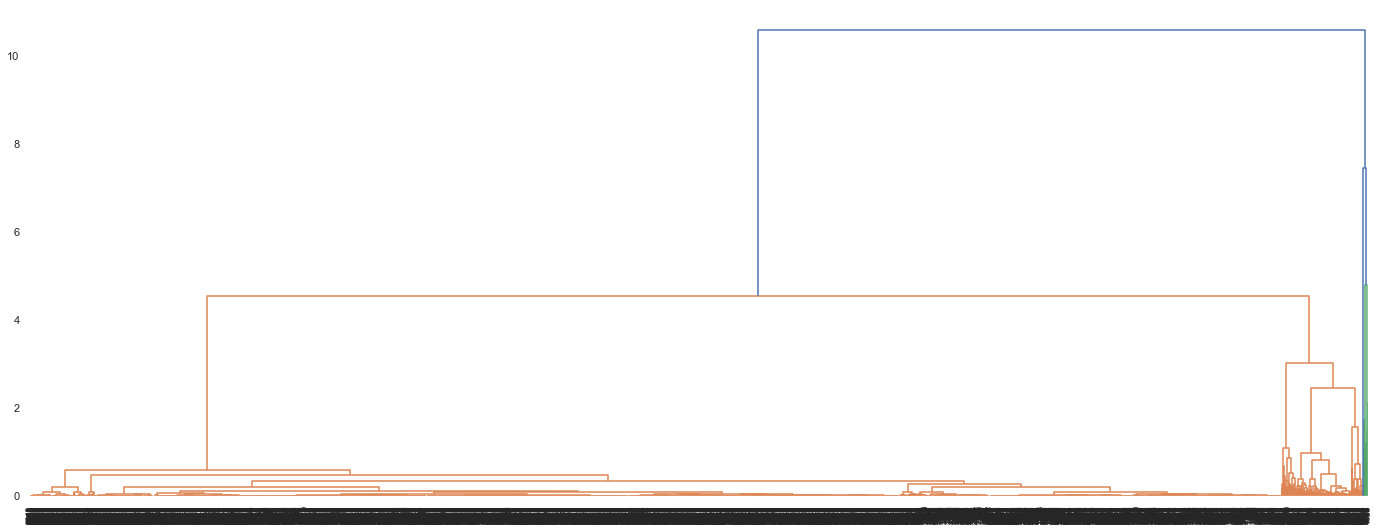

In [261]:
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

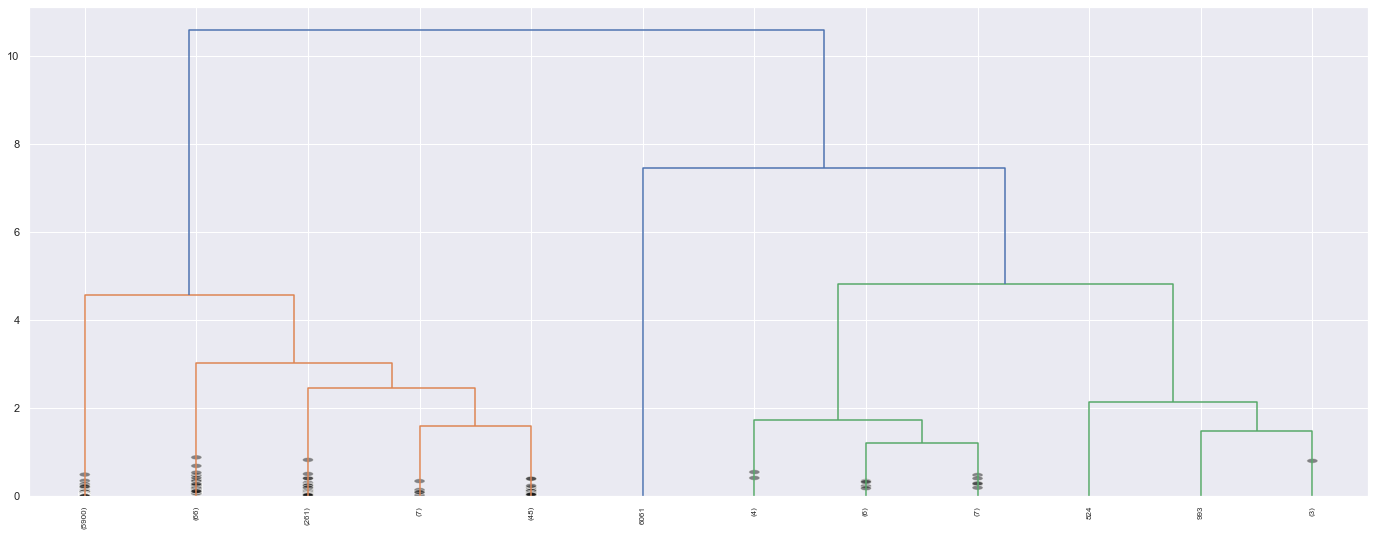

In [262]:
hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

### 7.3.1. HClustering Silhouette Score

In [263]:
from sklearn import metrics as m

In [264]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

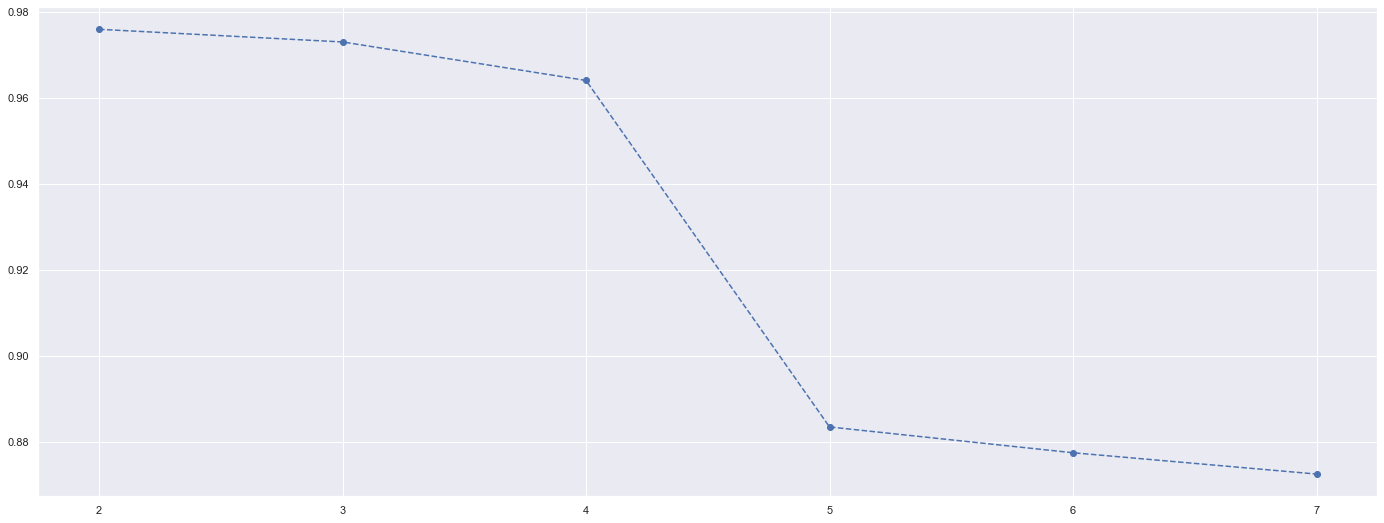

In [265]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [273]:
eps=0.1
min_samples=4

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
print( unique( labels ) )

Silhouette Score: 0.9082523094116223
Number of Clusters: 4
[-1  0  1  2]


In [274]:
from sklearn.neighbors import NearestNeighbors

In [275]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

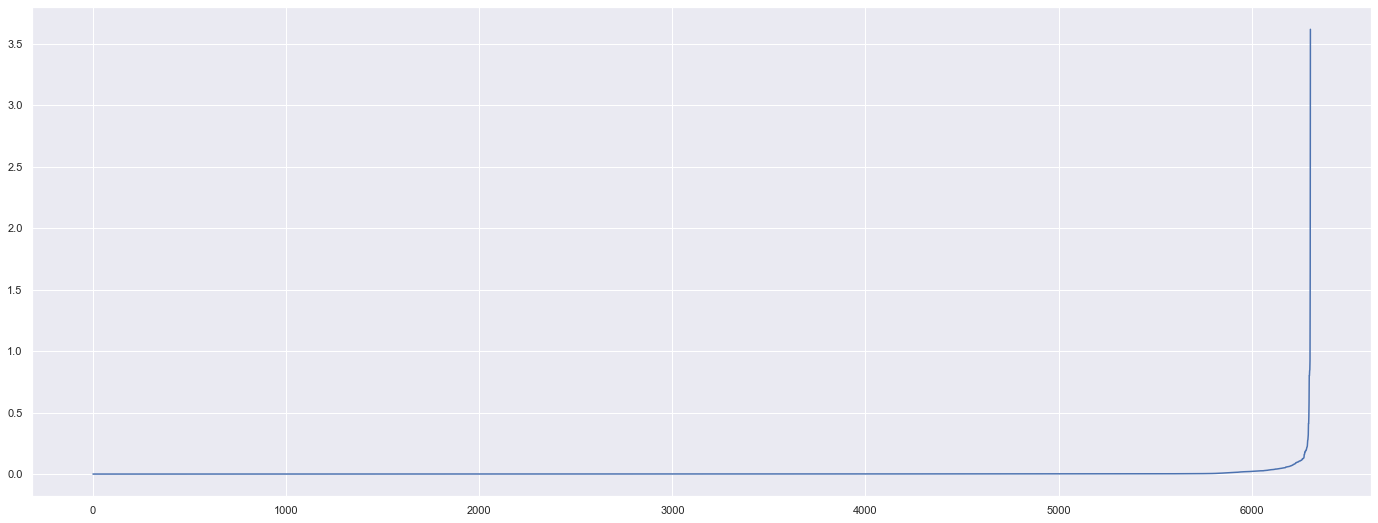

In [276]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

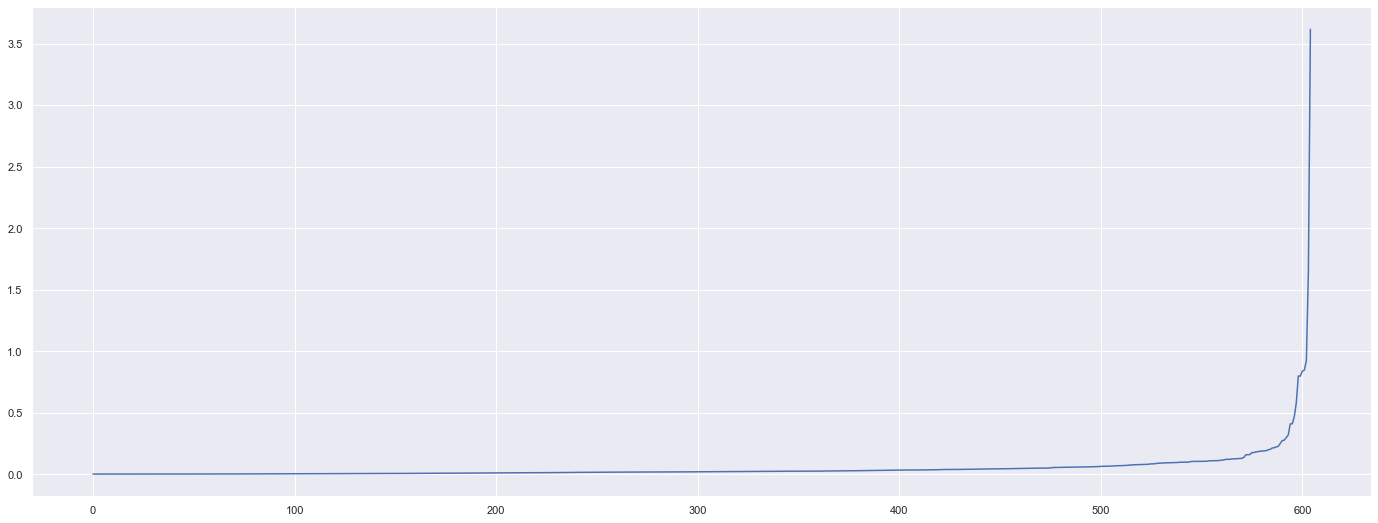

In [277]:
plt.plot( distances[5700:] )

## 7.5. Results

In [278]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list, 
     #'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters

In [279]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7
KMeans,0.986981,0.942579,0.942749,0.912949,0.914568,0.914536
GMM,0.986981,0.863044,0.861521,0.836311,0.858903,0.834215
HC,0.975877,0.972937,0.963997,0.883537,0.877546,0.872598


## 7.6. Silhouette Analysis

In [203]:
len(clusters)

6

 For K = 2. Silhouette Score: 0.975877184964686
 For K = 3. Silhouette Score: 0.9729372444516142
 For K = 4. Silhouette Score: 0.9639968051625802
 For K = 5. Silhouette Score: 0.8835374766332552
 For K = 6. Silhouette Score: 0.877545840859672
 For K = 7. Silhouette Score: 0.8725980158487884


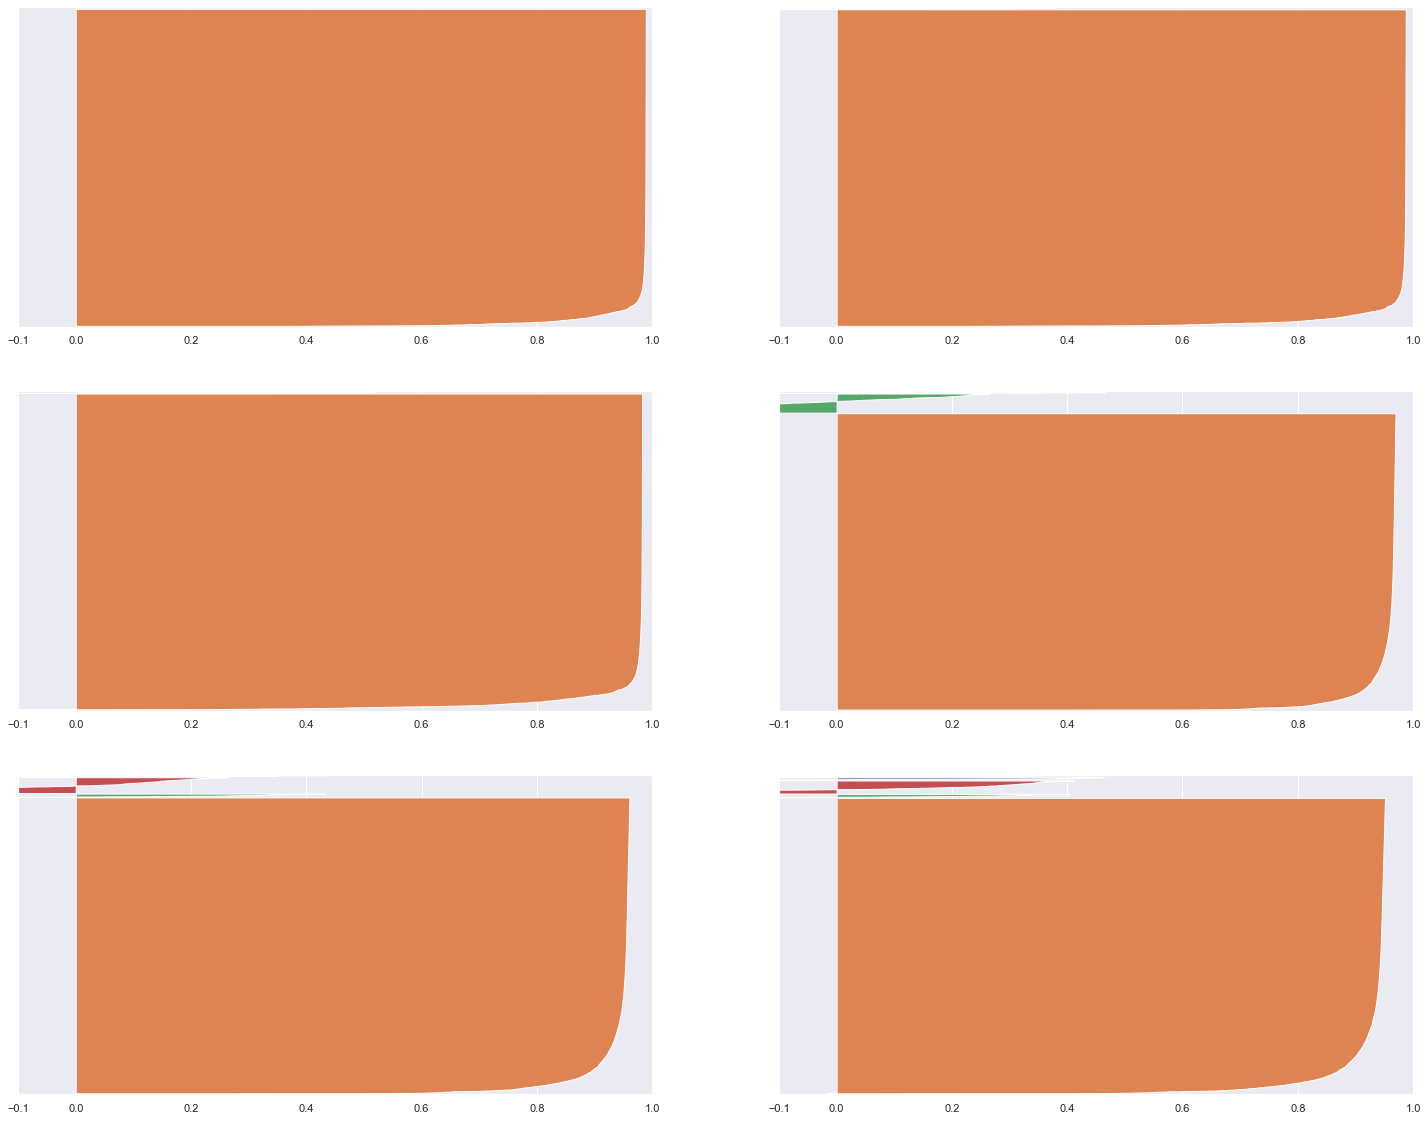

In [280]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# <font color='red'> 8.0 HYPERPARAMETER FINE TUNNING </font>

## 8.1. K-Means

In [281]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42) #max_iter iterações para achar o centróide

# model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [282]:
## WSS (within-cluster sum of square)
print('WSS Values: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS Values: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Values: 41.81771590235668
SS Values: 0.9425790849646982


# <font color='red'> 9.0. Cluster Analysis </font>

In [293]:
df9 = df5_p.copy()
df9['cluster'] = labels
df9['uf_municipio'] = df5_p['uf_municipio']
df9.head()

,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_pop_total,s_dom_part_perm,s_pct_criancas,s_pct_adolescente,s_pct_jovens,s_pct_adultos,s_pct_senior,s_pct_idosos,s_renda_media_familiar,s_densidade_populacao_km2,s_pct_classe_a,s_pct_classe_b,s_pct_classe_c,s_pct_classe_d,s_pct_classe_e,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_renda_per_capita,s_comercializacao,s_qtd_empresas,s_pct_cnae_agricola,s_pct_cnae_comercio,s_pct_cnae_constr_civil,s_pct_cnae_industria,s_pct_cnae_servicos,s_pct_cnae_outros,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,setor_ativ,uf_municipio,cluster
0,984.583,3275.396,0.000,0.000,14203.167,4647.917,33.354,39.149,43.530,51.630,20.171,12.147,3155.950,96.888,0.293,9.244,53.144,86.422,50.898,6.954,11.102,0.550,1038.227,11.910,822.083,2.445,92.585,7.517,21.214,68.465,7.489,634.417,74.833,27.583,7.667,3.833,2.000,1.833,0.000,0.000,0.000,9.333,16.583,1.833,0.000,33.250,2,AC / ACRELANDIA,0
1,5552.071,3573.109,0.000,0.000,54681.214,18692.071,47.891,53.869,61.321,85.290,32.774,18.839,5534.346,5898.858,0.710,27.783,78.495,122.922,70.072,9.666,15.159,-1.881,1904.889,30.599,3955.571,0.856,183.710,10.237,15.910,85.624,3.669,2782.071,416.500,124.571,49.857,12.143,2.857,3.643,1.000,2.857,0.000,51.857,44.857,53.429,9.643,191.143,3,AC / BRASILEIA,0
2,1296.000,4918.170,0.000,0.000,15882.000,4854.000,49.080,66.570,68.970,73.110,27.930,14.340,5371.170,316.740,0.000,12.420,81.390,130.170,76.020,24.360,28.800,5.790,1645.020,17.460,894.000,10.068,137.919,11.073,30.201,103.692,7.050,726.000,66.000,15.000,9.000,0.000,3.000,0.000,3.000,0.000,0.000,6.000,9.000,6.000,3.000,36.000,3,AC / CAPIXABA,0
3,12300.518,4661.355,5.556,11.259,122316.426,34380.481,67.384,84.996,81.034,110.332,37.329,18.908,7040.787,4273.300,2.598,31.581,98.521,159.245,108.032,11.553,22.211,3.385,1978.355,43.208,8267.371,1.760,197.183,17.746,28.091,152.265,2.760,6163.463,746.019,239.056,136.444,73.000,17.111,3.241,0.703,0.000,2.074,69.445,55.574,86.741,7.334,757.426,4,AC / CRUZEIRO DO SUL,0
4,1659.118,1247.426,0.000,0.000,12672.118,4344.294,17.721,18.045,20.228,27.495,10.671,5.835,1721.901,1188.041,0.429,9.239,24.962,41.403,23.958,2.965,4.888,0.386,593.696,9.656,1016.059,0.205,60.530,2.595,5.837,29.361,1.461,696.000,116.588,37.412,13.882,3.824,0.412,1.882,0.941,0.412,0.000,13.765,9.529,15.353,2.941,47.471,1,AC / EPITACIOLANDIA,0


In [284]:
df9.shape

(6305, 49)

In [294]:
df9 = df9.iloc[:, [0, 1, 4, 46, 47, 48]]

In [295]:
df9.head()

,trabalhadores,s_renda_media,s_pop_total,setor_ativ,uf_municipio,cluster
0,984.583,3275.396,14203.167,2,AC / ACRELANDIA,0
1,5552.071,3573.109,54681.214,3,AC / BRASILEIA,0
2,1296.000,4918.170,15882.000,3,AC / CAPIXABA,0
3,12300.518,4661.355,122316.426,4,AC / CRUZEIRO DO SUL,0
4,1659.118,1247.426,12672.118,1,AC / EPITACIOLANDIA,0


## 9.1. Visualization Inspection

In [296]:
fig = px.scatter_3d(df9, x='trabalhadores', y='s_renda_media', z='s_pop_total', color='cluster')
fig.show()

## 9.2. 2d plot

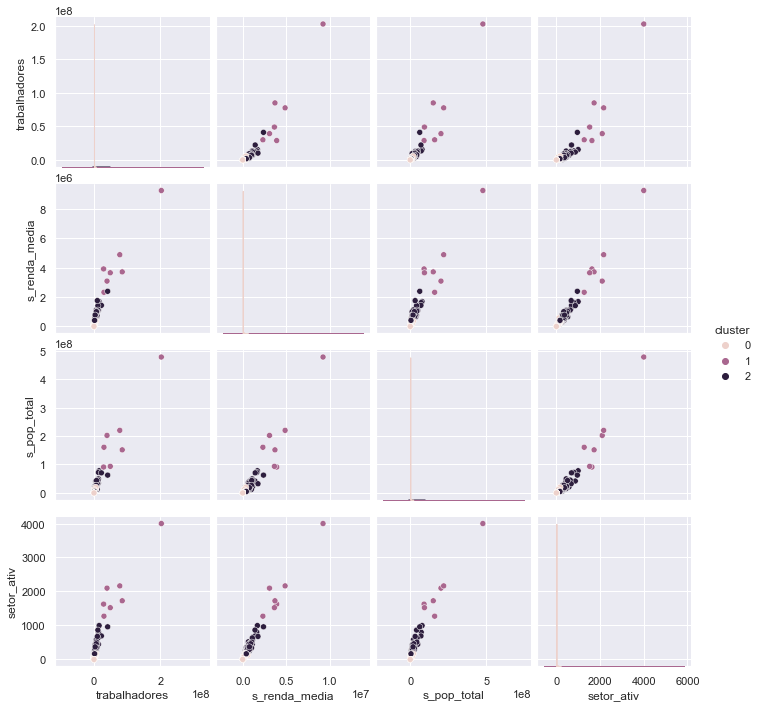

In [297]:
df_viz = df9.drop( columns='uf_municipio', axis=1 )
sns.pairplot( df_viz, hue='cluster' )

## 9.1. Cluster Profile

In [300]:
df_cluster = pd.DataFrame()
# Number of municipio
df_cluster = df9[['uf_municipio', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_municipio'] = 100*(df_cluster['uf_municipio'] / df_cluster['uf_municipio'].sum())

# Avg trabalhador
df_avg_trabalhador = df9[['trabalhadores', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'trabalhadores':'avg_trabalhadores'})
df_avg_trabalhador['avg_trabalhadores'] = df_avg_trabalhador['avg_trabalhadores'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_trabalhador, how='inner', on='cluster')

# Avg renda media
df_avg_renda_media = df9[['s_renda_media', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'s_renda_media':'avg_renda_media'})
df_avg_renda_media['avg_renda_media'] = df_avg_renda_media['avg_renda_media'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_renda_media, how='inner', on='cluster')

# Avg pop total
df_avg_pop_total = df9[['s_pop_total', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'s_pop_total':'avg_pop_total'})
df_avg_pop_total['avg_pop_total'] = df_avg_pop_total['avg_pop_total'].apply(lambda x: np.round(x, 0))
df_cluster = pd.merge(df_cluster, df_avg_pop_total, how='inner', on='cluster')

In [301]:
df_cluster.sort_values('avg_renda_media', ascending=False)

,cluster,uf_municipio,perc_municipio,avg_trabalhadores,avg_renda_media,avg_pop_total
1,1,7,0.111023,73300724.69,4392164.38,199371658.0
2,2,88,1.395718,4846865.15,628523.23,19159968.0
0,0,6210,98.493259,40246.12,9894.02,206295.0


### Cluster 01:  ( Candidatos a Vem de Bolo )
    - Número de Municípios: 7 (0.11% of customers )
    - N° médio de Trabalhadores: 73.300.725
    - Renda Média: R$ 4.392.164,38
    - População Média: 199.371.658 hab
        
### Cluster 02:
    - Número de Municípios: 88 (1,39% of customers )
    - N° médio de Trabalhadores: 4.846.865
    - Renda Média: R$ 628.523,23
    - População Média: 19.159.968 hab

### Cluster 03:
    - Número de Municípios: 6210 (98,58% of customers )
    - N° médio de Trabalhadores: 40.246
    - Renda Média: R$ 9.894,02
    - População Média: 206.295 hab


In [302]:
df9[df9['cluster'] == 1].sort_values('s_renda_media', ascending=False).head(25)

,trabalhadores,s_renda_media,s_pop_total,setor_ativ,uf_municipio,cluster
6061,2.029613e+08,9228251.300,4.774866e+08,3999,SP / SAO PAULO,1
4044,7.775105e+07,4869705.155,2.198219e+08,2165,RJ / RIO DE JANEIRO,1
993,2.892130e+07,3904016.984,9.096376e+07,1629,DF / BRASILIA,1
1628,8.511197e+07,3704476.045,1.513921e+08,1727,MG / BELO HORIZONTE,1
3572,4.906963e+07,3641903.966,9.338321e+07,1524,PR / CURITIBA,1
824,3.925256e+07,3078247.923,2.020703e+08,2099,CE / FORTALEZA,1
648,3.003725e+07,2318549.273,1.604837e+08,1274,BA / SALVADOR,1
